# Import libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#Author: Sanjay Kottapalli, Dana Pe'er lab (kottapas@mskcc.org)

import numpy as np
import numpy.matlib
import pandas as pd
import scanpy as sc
from scanpy.external.pp import magic
import scipy
from sklearn.metrics import adjusted_rand_score
from scipy.stats.mstats import zscore
from scipy.stats import pearsonr
import csv
import os
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from copy import deepcopy
import timeit
from joblib import Parallel, delayed
from collections import Counter
np.random.seed(0)

# Define functions

In [3]:
def import_seqc_data(sample_name, path, dense=True):
    print('\nsample: ' + sample_name)
    if dense:
        PATH_TO_COUNT_CSV = path + sample_name + '_dense.csv'
        # import csv
        raw_counts = pd.read_csv(PATH_TO_COUNT_CSV, index_col=0, header=0)
        print(raw_counts.shape)
        #
        with open(PATH_TO_COUNT_CSV, "r") as f:
            reader = csv.reader(f)
            original_column_names = next(reader)
        # remove the first entry of this list, it belongs to the index column
        gene_names = original_column_names[1:]
        # and label the index column with name 'cell_barcodes'
        raw_counts.index.name = 'cell_barcodes'
        # convert indices to strings instead of integers for compatibility with scanpy
        raw_counts.index = raw_counts.index.astype(str)
        # python automatically converts duplicate column names to numbered column names,
        # e.g. 'X', 'X.1', 'X.2' etc. We can import the original column names from our CSV file:

        # now transpose the dataframe (for compatibility with panda's groupby function), 
        # then group by gene names, and add up the counts for genes with the same name
        raw_counts_transposed = raw_counts.T
        raw_counts_transposed_clean = raw_counts_transposed.groupby(gene_names, axis='index', sort=False).agg('sum')
        # transpose back
        raw_counts_clean = raw_counts_transposed_clean.T
        # if columns were added up, print how many:
        number_of_columns_removed = raw_counts.shape[1] - raw_counts_clean.shape[1]
        if number_of_columns_removed > 0:
            print(str(number_of_columns_removed) + ' columns were each merged with another column that had the same gene name.')
        # remove CLUSTER column:
        if 'CLUSTER' in raw_counts_clean.columns:
            raw_counts_clean.drop(columns='CLUSTER', inplace=True)
        # convert index type to string for compatibility with scanpy
        raw_counts_clean.index = raw_counts_clean.index.astype('str')
        adata = sc.AnnData(X = raw_counts_clean)
    else:
        barcodes = pd.read_csv(path+sample_name+'_sparse_counts_barcodes.csv', index_col=0, header=None)
        barcodes = barcodes[1].values
        barcodes = [str(i) for i in barcodes]
        gene_names = pd.read_csv(path+sample_name+'_sparse_counts_genes.csv', index_col=0, header=None)
        gene_names = gene_names[1].values
        sparse_counts = scipy.io.mmread(path+sample_name+'_sparse_molecule_counts.mtx').tocsc()
        #print("# of bytes: "+str(sparse_counts.data.nbytes))
        print(sparse_counts.shape)
        #sparse_counts = sparse_counts.toarray()#np.array(sparse_counts)
        #print(sparse_counts.shape)
        #raw_counts = pd.DataFrame.sparse.from_spmatrix(data=sparse_counts, index=barcodes, columns=gene_names)
        
        gene_dup = pd.Series(dict(Counter(gene_names)))
        gene_dup = gene_dup[gene_dup>1]
        #print(gene_dup)
        #print(len(set(gene_names)))
        gene_dup = list(gene_dup.keys())
        number_of_columns_removed = len(gene_dup)
        
        # sum of duplicate columns for each duplicate gene
        sum_dict = {i:sparse_counts[:,np.where(gene_names==i)[0]].sum(axis=1) for i in gene_dup}
        dup_index = []
        for i in gene_dup:
            dup_index += list(np.where(gene_names==i)[0])
        #print(sum_dict)
        #print(len(dup_index))
        #for i in sum_dict:
        #    print(sum_dict[i].sum(axis=0))
        
        #print(len(gene_names), sparse_counts.shape)
        keep_index = list(set(range(len(gene_names))) - set(dup_index))
        new_genes = list(gene_names[keep_index])
        new_counts = sparse_counts[:, keep_index]
        #print(len(new_genes), new_counts.shape)
        #print(new_counts.shape, type(new_counts))
        for i in sum_dict.keys():
            #print(sum_dict[i])
            #print(type(new_counts), type(sum_dict[i]))
            new_counts = scipy.sparse.hstack([new_counts, sum_dict[i]])
            new_genes.append(i)
        #print(len(new_genes), new_counts.shape)
        new_counts = new_counts.tocsc()
        print(new_counts.shape)#, type(new_counts))
        
        adata = sc.AnnData(X = new_counts, obs=pd.DataFrame(index=barcodes), var=pd.DataFrame(index=new_genes))
        
        if number_of_columns_removed > 0:
            print(str(number_of_columns_removed) + ' columns were each merged with another column that had the same gene name.')
       # take the min libsize in the dense cells, and 
        
        adata, mito_genes, RB_genes_in_data = qc_metrics(adata)
        # remove high mito frac cells
        cutoff = 20.0
        mito_val = adata.obs['pct_counts_mito']
        #print(mito_val)
        via_cells = mito_val[mito_val<cutoff]
        #print(via_cells)
        adata = adata[via_cells.index, :]
        print(adata.shape)
        
        PATH_TO_COUNT_CSV = path + sample_name + '_dense.csv'
        raw_counts = pd.read_csv(PATH_TO_COUNT_CSV, index_col=0, header=0)
        seqc_cells = [str(i) for i in raw_counts.index]
        libsize = adata.obs['original_total_counts'].sort_values(ascending=False)
        #pd.Series(index=adata.obs.index, data=np.array(np.sum(adata.X, axis=1).flatten())[0], dtype=str).sort_values(ascending=False)
        
        #difference = set(seqc_cells)-set([str(i) for i in libsize.iloc[:len(seqc_cells)+15000].index])
        #print(len(seqc_cells),len(difference))
        #print(seqc_cells[:20])
        #print(libsize.iloc[:20])
        
        adata = adata[libsize.iloc[:len(seqc_cells)+15000].index, :] # all dense cells + 15,000
        adata = sc.AnnData(X = adata.X, obs=pd.DataFrame(index=adata.obs.index), var=pd.DataFrame(index=adata.var.index))
        print(adata.shape)
        print("Cells filtered.")
    
    return adata

In [4]:
def qc_metrics(adata, path_RB=''):
    mito_genes = adata.var_names.str.startswith('MT-')
    adata.var['mito'] = mito_genes
    mito_genes = np.array(adata.var.index)[mito_genes]
    
    path_RB = path_RB+'RB_genes_human'
    with open(path_RB,'r') as file:
        lines = file.readlines()
    RB_genes = [x.rstrip('\n') for x in lines]
    data_genes = list(adata.var.index)
    RB_genes_in_data = set(data_genes).intersection(RB_genes)
    RB_genes_in_data = list(RB_genes_in_data)
    
    adata.var['ribo'] = False
    adata.var.loc[RB_genes_in_data, 'ribo'] = True
    
    sc.pp.calculate_qc_metrics(adata, qc_vars=('mito', 'ribo'), inplace=True)
    adata.obs['original_total_counts'] = adata.obs['total_counts']
    adata.obs['log10_original_total_counts'] = np.log10(adata.obs['original_total_counts'])
    print('QC metrics calculated.')
    
    return adata, mito_genes, RB_genes_in_data

In [5]:
def norm_filter(adata, mito_genes, RB_genes_in_data
                , log=True, remove_ribo=True, remove_mito=True, highly_var=False, markers=[]):
    
    adata.layers['raw_counts'] = adata.X
    # filter genes expressed in few cells
    print(adata.shape)
    sc.pp.filter_genes(adata, min_cells = 10)
    print(adata.shape)
    
    # libsize normalize
    if type(adata.X)==np.ndarray:
        med_libsize = np.median(np.sum(adata.X, axis=1))
    else:
        sums = np.array(np.sum(adata.X, axis=1).flatten())[0]
        #med_libsize = np.median(sums)
        if min(sums) == 0:
            empty_cells = set(np.where(sums==0)[0])
            print('# of 0-count droplets: '+str(len(empty_cells)))
            all_cells = set(adata.obs.index)
            keep_cells = all_cells-empty_cells
            adata = adata[keep_cells, :]
            sums = np.array(np.sum(adata.X, axis=1).flatten())[0]
        med_libsize = np.median(sums)

        print('Median library size: ' + str(med_libsize))

    sc.pp.normalize_total(adata)

    # log transform
    if log:
        adata.X = np.log2(adata.X+0.1) - np.log2(0.1)

        for i in deepcopy(markers):
            try:
                adata.obs[i+'_exp'] = adata[:,i].X
            except:
                markers.remove(i)
                print(i)

    else:
        for i in deepcopy(markers):
            try:
                adata.obs[i+'_exp'] = np.log2(adata[:,i].X+0.1)
            except:
                markers.remove(i)
                print(i)

    # remove ribosomal genes
    if remove_ribo:
        RB_genes_in_data.append('MALAT1')
        adata = adata[:,[x not in RB_genes_in_data for x in adata.var.index]]
        print(adata.shape)

    # remove mitochondrial genes
    if remove_mito:
        adata = adata[:,[x not in mito_genes for x in adata.var.index]]
        print(adata.shape)

    # highly variable gene selection
    print(highly_var)
    if highly_var:
        if not log:
            print('Im here1')
            sc.pp.highly_variable_genes(adata, layer='raw_counts', flavor='seurat_v3',max_mean=np.inf, n_top_genes=2000)#, batch_key='Sample ID')
            print(sum(adata.var['highly_variable']))
            adata.var.loc[markers, 'highly_variable'] = True
            print(sum(adata.var['highly_variable']))
            print(adata.shape)
        elif log:
            print('Im here2')
            sc.pp.highly_variable_genes(adata, layer=None, flavor='cell_ranger', max_mean=np.inf, n_top_genes=2000)#, batch_key='Sample ID')
            print(sum(adata.var['highly_variable']))
            adata.var.loc[markers, 'highly_variable'] = True
            print(sum(adata.var['highly_variable']))

    return adata, markers#adata_unlog, markers

In [6]:
def plot_pca(adata):
    #print("I am in here 1")
    
    print(adata.X)
    try:
        print(adata.shape)
        N = 1000
        adata_new = sc.tl.pca(adata, n_comps=N, copy = True)
    except:
        print(adata.shape) 
        N = min(adata.shape) - 1
        adata_new = sc.tl.pca(adata, n_comps=N, copy = True)
    
    #Plot variance explained
    x = range(len(adata_new.uns['pca']['variance_ratio']))
    y = adata_new.uns['pca']['variance_ratio']
    plt.scatter(x,y,s=4)
    plt.xlabel('PC')
    plt.ylabel('Fraction of variance explained')
    plt.title('Fraction of variance explained per PC')
    plt.show()
    
    #Plot cumulative variance
    cml_var_explained = np.cumsum(adata_new.uns['pca']['variance_ratio'])
    x = range(len(adata_new.uns['pca']['variance_ratio']))
    y = cml_var_explained
    plt.scatter(x,y,s=4)
    plt.xlabel('PC')
    plt.ylabel('Cumulative fraction of variance explained')
    plt.title('Cumulative fraction of variance explained by PCs')
    plt.show()
    
    return cml_var_explained, adata_new.uns['pca']['variance_ratio']
    
def kneepoint(vec):
    #print("I am in here 4")
    curve =  [1-x for x in vec]
    nPoints = len(curve)
    allCoord = np.vstack((range(nPoints), curve)).T
    np.array([range(nPoints), curve])
    firstPoint = allCoord[0]
    lineVec = allCoord[-1] - allCoord[0]
    lineVecNorm = lineVec / np.sqrt(np.sum(lineVec**2))
    vecFromFirst = allCoord - firstPoint
    scalarProduct = np.sum(vecFromFirst * numpy.matlib.repmat(lineVecNorm, nPoints, 1), axis=1)
    vecFromFirstParallel = np.outer(scalarProduct, lineVecNorm)
    vecToLine = vecFromFirst - vecFromFirstParallel
    distToLine = np.sqrt(np.sum(vecToLine ** 2, axis=1))
    idxOfBestPoint = np.argmax(distToLine)
    
    return idxOfBestPoint
    
def run_pca_knee(adata):
    cml, var = plot_pca(adata)

    knee = kneepoint(var)
    
    print("Knee point: "+str(knee))
    print("Explained variance: " + str(cml[knee]))

    x=list(range(len(cml)))
    plt.plot(x[:5*knee],cml[:5*knee])
    plt.show()

    adata_new = sc.tl.pca(adata, n_comps=knee+1, copy=True)
    sc.pl.pca_loadings(adata_new, components=range(1,4))
    
    return adata_new

In [7]:
godsnot_64 = [
    # "#000000",  # remove the black, as often, we have black colored annotation
    "#d9d929", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
    "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
    "#5A0007", "#809693", "#6A3A4C", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
    "#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
    "#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
    "#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
    "#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
    "#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
    "#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81",
    "#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00",
    "#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700",
    "#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329",
    "#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72"]

# Populate input parameters

In [8]:
# populate from command line
samples = ['1819_C1029_Ctrl_ES_Cort_IGO_10837_23', '1820_C1029_Ctrl_ES_BS_IGO_10856_3', '1821_996_VE_ES_Cort_IGO_10875_6', '1822_996_VE_ES_BS_IGO_10875_7']
indir = './input/'
outdir = './output_Nov/'
figures = './figures/'

In [9]:
adata_final_high_var = sc.read_h5ad(outdir+'adata_final_high_var_final_clusters_updated.h5ad')

In [10]:
adata_final_high_var.shape

(23060, 18947)

# Excitatory neurons subset

In [11]:
adata_exci = deepcopy(adata_final_high_var)
adata_exci = adata_exci[adata_exci.obs['final_subclusters'].isin(['Excitatory_neurons']),:]
adata_exci.shape

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(7232, 18947)

In [12]:
broad_clusters = adata_exci.obs['Condition']
unique_clusters = np.unique(broad_clusters.values)
samples = adata_exci.obs['Sample ID']
print('Cell counts in each cluster for each sample: ')

for cluster in unique_clusters:
    print('Cluster: '+str(cluster))
    index = broad_clusters[broad_clusters==cluster].index
    count = Counter(samples[index].values)
    print(count)

Cell counts in each cluster for each sample: 
Cluster: Control
Counter({'1819_C1029_Ctrl_ES_Cort_IGO_10837_23': 2789, '1820_C1029_Ctrl_ES_BS_IGO_10856_3': 228})
Cluster: VE
Counter({'1821_996_VE_ES_Cort_IGO_10875_6': 3627, '1822_996_VE_ES_BS_IGO_10875_7': 588})


In [13]:
path_to_h5ad_file = outdir+'adata.h5ad'
adata = sc.read_h5ad(path_to_h5ad_file)
print(adata)
# Add a new column describing the sample condition
adata.obs['Condition'] = np.where(adata.obs['Sample ID'] == '1819_C1029_Ctrl_ES_Cort_IGO_10837_23', "Control", "NA")
adata.obs['Condition'] = np.where(adata.obs['Sample ID'] == '1820_C1029_Ctrl_ES_BS_IGO_10856_3', "Control", adata.obs['Condition'])
adata.obs['Condition'] = np.where(adata.obs['Sample ID'] == '1821_996_VE_ES_Cort_IGO_10875_6', "VE", adata.obs['Condition'])
adata.obs['Condition'] = np.where(adata.obs['Sample ID'] == '1822_996_VE_ES_BS_IGO_10875_7', "VE", adata.obs['Condition'])


adata.obs.head()

AnnData object with n_obs × n_vars = 26101 × 22292
    obs: 'Sample ID'


Sample ID  \
cell_barcodes                                                                              
120703436570020_1819_C1029_Ctrl_ES_Cort_IGO_108...  1819_C1029_Ctrl_ES_Cort_IGO_10837_23   
120703455227244_1819_C1029_Ctrl_ES_Cort_IGO_108...  1819_C1029_Ctrl_ES_Cort_IGO_10837_23   
120703455251884_1819_C1029_Ctrl_ES_Cort_IGO_108...  1819_C1029_Ctrl_ES_Cort_IGO_10837_23   
120703455704877_1819_C1029_Ctrl_ES_Cort_IGO_108...  1819_C1029_Ctrl_ES_Cort_IGO_10837_23   
120718441244516_1819_C1029_Ctrl_ES_Cort_IGO_108...  1819_C1029_Ctrl_ES_Cort_IGO_10837_23   

                                                   Condition  
cell_barcodes                                                 
120703436570020_1819_C1029_Ctrl_ES_Cort_IGO_108...   Control  
120703455227244_1819_C1029_Ctrl_ES_Cort_IGO_108...   Control  
120703455251884_1819_C1029_Ctrl_ES_Cort_IGO_108...   Control  
120703455704877_1819_C1029_Ctrl_ES_Cort_IGO_108...   Control  
120718441244516_1819_C1029_Ctrl_ES_Cort_IGO_108...   Control

In [14]:
# Add a new column describing the sample condition
adata.obs['B_region'] = np.where(adata.obs['Sample ID'] == '1819_C1029_Ctrl_ES_Cort_IGO_10837_23', "Cortex", "NA")
adata.obs['B_region'] = np.where(adata.obs['Sample ID'] == '1820_C1029_Ctrl_ES_BS_IGO_10856_3', "BrainStem", adata.obs['B_region'])
adata.obs['B_region'] = np.where(adata.obs['Sample ID'] == '1821_996_VE_ES_Cort_IGO_10875_6', "Cortex", adata.obs['B_region'])
adata.obs['B_region'] = np.where(adata.obs['Sample ID'] == '1822_996_VE_ES_BS_IGO_10875_7', "BrainStem", adata.obs['B_region'])


#adata.obs
# count the number of NAs
sum(pd.isna(adata.obs['B_region']))

0

In [15]:
adata_exci = adata[adata_exci.obs.index, :]
adata_exci.shape

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(7232, 22292)

## QC

In [16]:
adata_exci, mito_genes, RB_genes_in_data = qc_metrics(adata_exci)
markers = []
if type(adata_exci.X)==np.ndarray:
    pass
else:
    print(type(adata_exci.X))
    #print(adata_norm.X.shape)
    adata_exci.X = adata_exci.X.toarray()
    #print(adata_norm.X.shape)
adata_exci.X = pd.DataFrame(data=adata_exci.X).fillna(0).values

Trying to set attribute `.var` of view, copying.


QC metrics calculated.
<class 'scipy.sparse.csr.csr_matrix'>


In [17]:
adata_exci.shape

(7232, 22292)

## Normalization

In [18]:
markers = []
adata_exci, markers = norm_filter(adata_exci, mito_genes, RB_genes_in_data, markers=[], highly_var=True)
adata_exci.obs.head()

(7232, 22292)


/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(7232, 17254)
(7232, 17067)
(7232, 17054)
True
Im here2


Trying to set attribute `.uns` of view, copying.


2000
2000


Sample ID  \
cell_barcodes                                                                      
170875902409948_1821_996_VE_ES_Cort_IGO_10875_6  1821_996_VE_ES_Cort_IGO_10875_6   
164693537680158_1821_996_VE_ES_Cort_IGO_10875_6  1821_996_VE_ES_Cort_IGO_10875_6   
227449318369526_1821_996_VE_ES_Cort_IGO_10875_6  1821_996_VE_ES_Cort_IGO_10875_6   
199823149099446_1822_996_VE_ES_BS_IGO_10875_7      1822_996_VE_ES_BS_IGO_10875_7   
192788812643699_1821_996_VE_ES_Cort_IGO_10875_6  1821_996_VE_ES_Cort_IGO_10875_6   

                                                Condition   B_region  \
cell_barcodes                                                          
170875902409948_1821_996_VE_ES_Cort_IGO_10875_6        VE     Cortex   
164693537680158_1821_996_VE_ES_Cort_IGO_10875_6        VE     Cortex   
227449318369526_1821_996_VE_ES_Cort_IGO_10875_6        VE     Cortex   
199823149099446_1822_996_VE_ES_BS_IGO_10875_7          VE  BrainStem   
192788812643699_1821_996_VE_ES_Cort_IGO_10875_6        VE     Cortex   

                                                 n_genes_by_counts  \
cell_barcodes                                                        
170875902409948_1821_996_VE_ES_Cort_IGO_10875_6               4570   
164693537680158_1821_996_VE_ES_Cort_IGO_10875_6               2350   
227449318369526_1821_996_VE_ES_Cort_IGO_10875_6               2367   
199823149099446_1822_996_VE_ES_BS_IGO_10875_7                 1608   
192788812643699_1821_996_VE_ES_Cort_IGO_10875_6               1566   

                                                 log1p_n_genes_by_counts  \
cell_barcodes                                                              
170875902409948_1821_996_VE_ES_Cort_IGO_10875_6                 8.427487   
164693537680158_1821_996_VE_ES_Cort_IGO_10875_6                 7.762596   
227449318369526_1821_996_VE_ES_Cort_IGO_10875_6                 7.769801   
199823149099446_1822_996_VE_ES_BS_IGO_10875_7                   7.383368   
192788812643699_1821_996_VE_ES_Cort_IGO_10875_6                 7.356918   

                                                 total_counts  \
cell_barcodes                                                   
170875902409948_1821_996_VE_ES_Cort_IGO_10875_6       15681.0   
164693537680158_1821_996_VE_ES_Cort_IGO_10875_6        5645.0   
227449318369526_1821_996_VE_ES_Cort_IGO_10875_6        5735.0   
199823149099446_1822_996_VE_ES_BS_IGO_10875_7          2964.0   
192788812643699_1821_996_VE_ES_Cort_IGO_10875_6        2920.0   

                                                 log1p_total_counts  \
cell_barcodes                                                         
170875902409948_1821_996_VE_ES_Cort_IGO_10875_6            9.660269   
164693537680158_1821_996_VE_ES_Cort_IGO_10875_6            8.638702   
227449318369526_1821_996_VE_ES_Cort_IGO_10875_6            8.654517   
199823149099446_1822_996_VE_ES_BS_IGO_10875_7              7.994632   
192788812643699_1821_996_VE_ES_Cort_IGO_10875_6            7.979681   

                                                 pct_counts_in_top_50_genes  \
cell_barcodes                                                                 
170875902409948_1821_996_VE_ES_Cort_IGO_10875_6                   20.636439   
164693537680158_1821_996_VE_ES_Cort_IGO_10875_6                   20.655447   
227449318369526_1821_996_VE_ES_Cort_IGO_10875_6                   23.836094   
199823149099446_1822_996_VE_ES_BS_IGO_10875_7                     21.761134   
192788812643699_1821_996_VE_ES_Cort_IGO_10875_6                   23.150685   

                                                 pct_counts_in_top_100_genes  \
cell_barcodes                                                                  
170875902409948_1821_996_VE_ES_Cort_IGO_10875_6                    28.206109   
164693537680158_1821_996_VE_ES_Cort_IGO_10875_6                    29.176262   
227449318369526_1821_996_VE_ES_Cort_IGO_10875_6                    32.938099   
199823149099446_1822_996_VE_ES_BS_IGO_10875_7

## PCA

[[-3.321928 -3.321928 -3.321928 ... -3.321928 -3.321928 -3.321928]
 [-3.321928 -3.321928 -3.321928 ... -3.321928 -3.321928 -3.321928]
 [-3.321928 -3.321928 -3.321928 ... -3.321928 -3.321928 -3.321928]
 ...
 [-3.321928 -3.321928 -3.321928 ... -3.321928 -3.321928 -3.321928]
 [-3.321928 -3.321928 -3.321928 ... -3.321928 -3.321928 -3.321928]
 [-3.321928 -3.321928 -3.321928 ... -3.321928 -3.321928 -3.321928]]
(7232, 17054)


/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


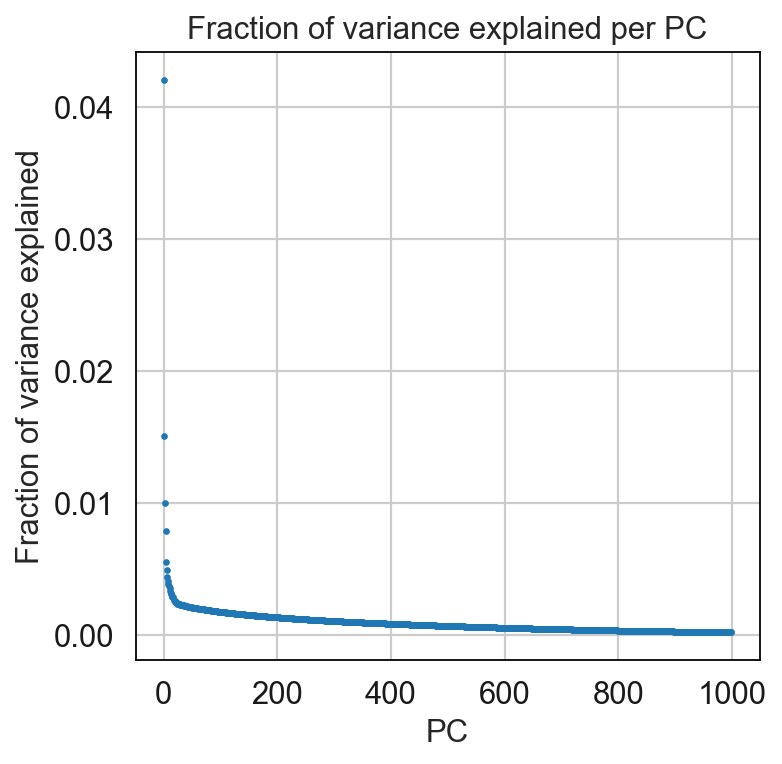

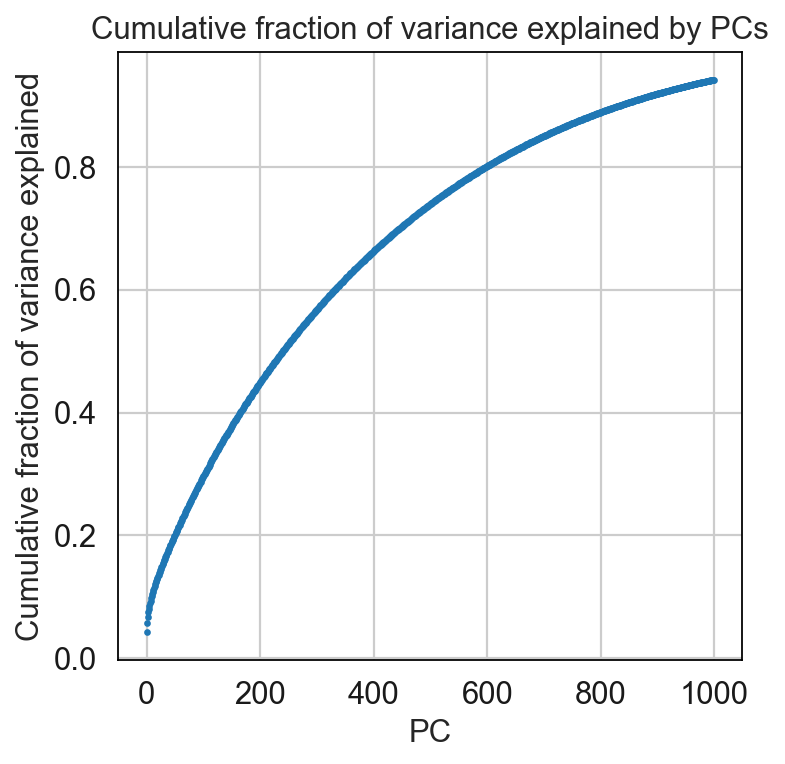

Knee point: 20
Explained variance: 0.13377438


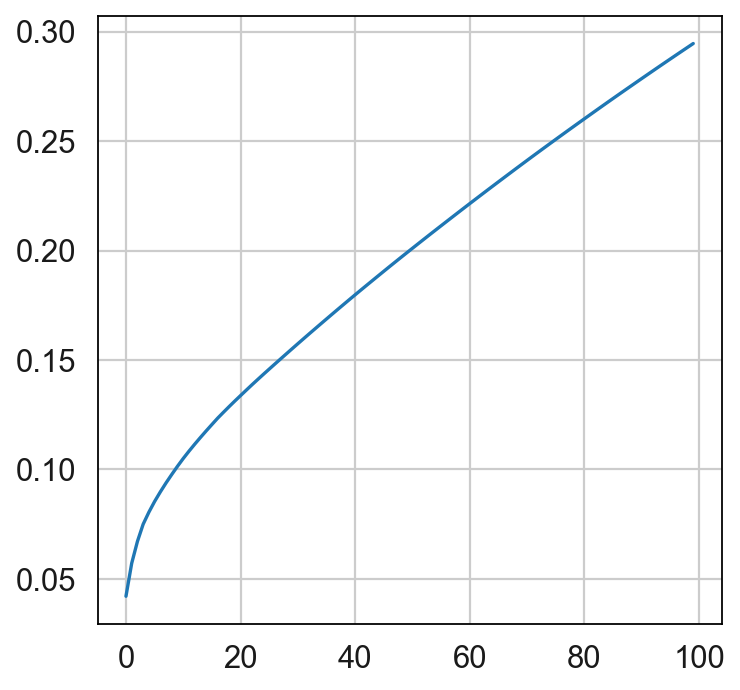

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0, flags=flags)


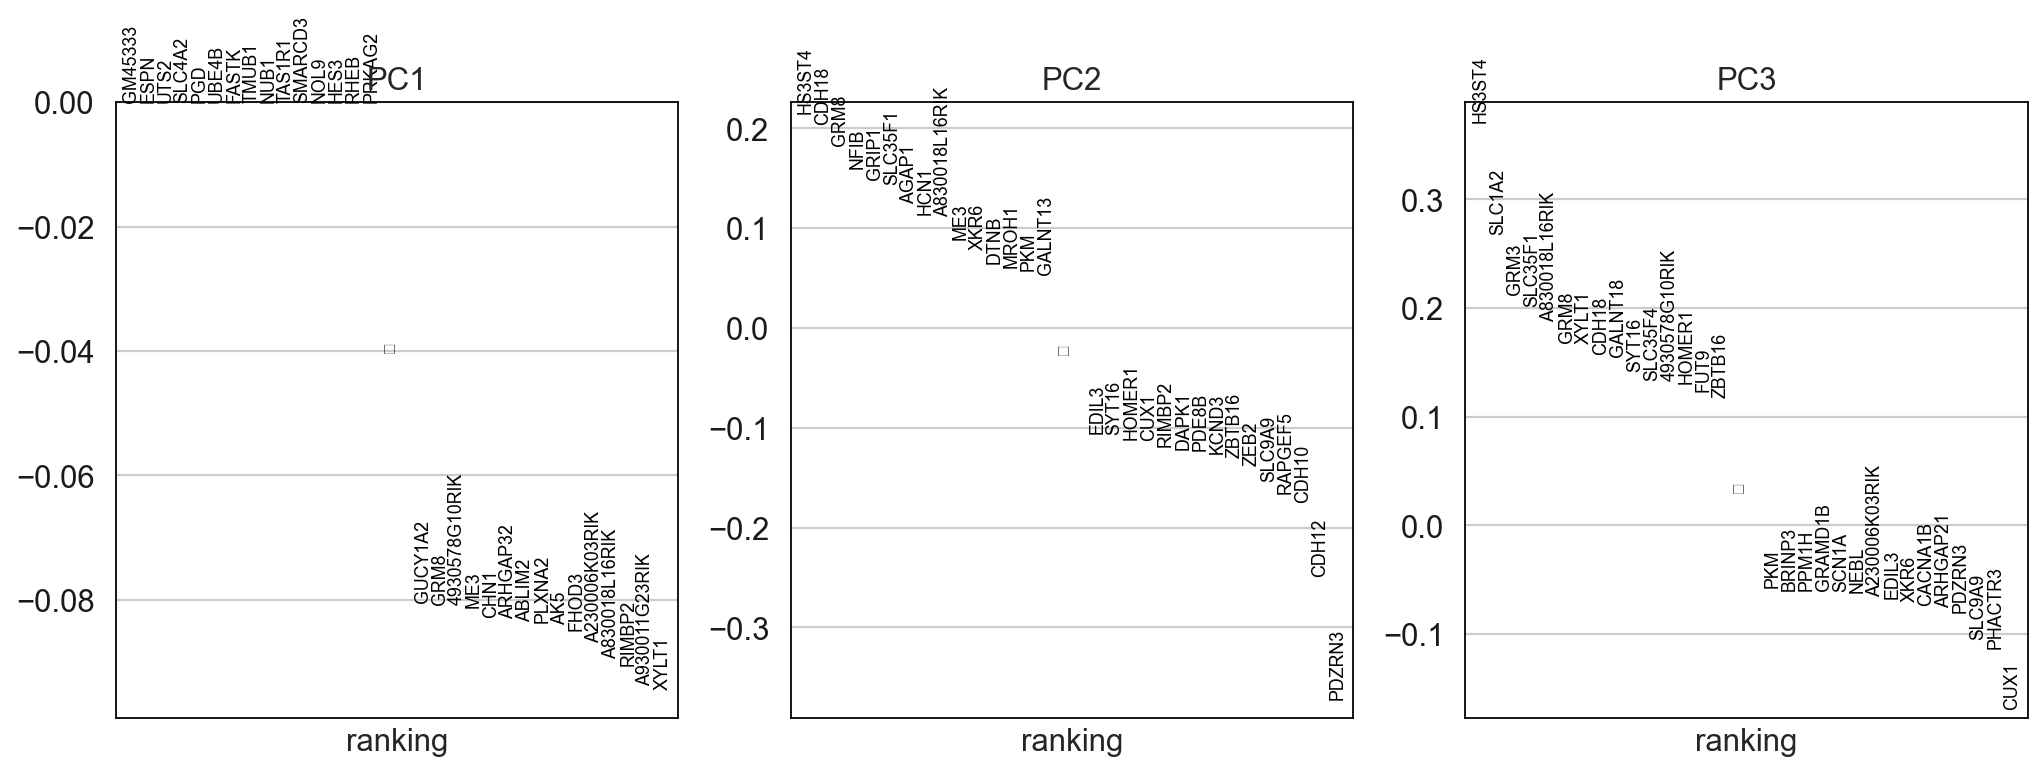

(7232, 17054)


/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [19]:
sc.set_figure_params(figsize=(5, 5))
adata_exci = run_pca_knee(adata_exci)#, 0.5)
adata_exci.obs['PC 1'] = adata_exci.obsm['X_pca'][:,0] # optional
adata_exci.obs['PC 2'] = adata_exci.obsm['X_pca'][:,1]
adata_exci.obs['PC 3'] = adata_exci.obsm['X_pca'][:,2]

print(adata_exci.shape)
adata_exci.X = pd.DataFrame(adata_exci.X).fillna(0).values
index_list = np.arange(adata_exci.shape[0])
np.random.shuffle(index_list)
adata_exci = adata_exci[index_list,:]

In [20]:
print(adata_exci.shape)
adata_exci.X = pd.DataFrame(adata_exci.X).fillna(0).values
index_list = np.arange(adata_exci.shape[0])
np.random.shuffle(index_list)
adata_exci = adata_exci[index_list,:]

(7232, 17054)


## Phenograph

Finding 10 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.6814849376678467 seconds
Jaccard graph constructed in 2.919908046722412 seconds
Wrote graph to binary file in 0.32813310623168945 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.850209
After 5 runs, maximum modularity is Q = 0.851547
Louvain completed 25 runs in 1.9451301097869873 seconds
Sorting communities by size, please wait ...
PhenoGraph complete in 6.568873882293701 seconds


Trying to set attribute `.obs` of view, copying.


Finding 15 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.5998539924621582 seconds
Jaccard graph constructed in 1.1670570373535156 seconds
Wrote graph to binary file in 0.21083402633666992 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.830289
After 3 runs, maximum modularity is Q = 0.831384
Louvain completed 23 runs in 2.3120267391204834 seconds
Sorting communities by size, please wait ...
PhenoGraph complete in 4.944411039352417 seconds
Finding 20 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.5575740337371826 seconds
Jaccard graph constructed in 1.1268651485443115 seconds
Wrote graph to binary file in 0.39069390296936035 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.818771
After 9 runs, maximum modularity is Q = 0.821455
Louvain completed 29 runs in 3.1452460289001465 seconds
Sorting communities by size, please wait ...
P

Text(0.5, 0, 'k')

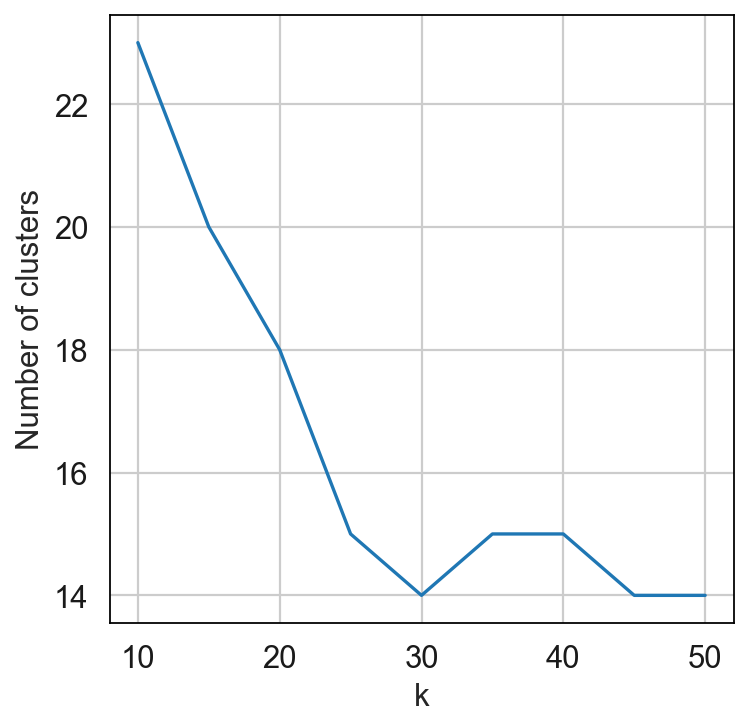

In [21]:
k_list = list(range(10, 55, 5))
n_clusters = []
for k in k_list:
    communities, graph, Q = sc.external.tl.phenograph(pd.DataFrame(adata_exci.obsm['X_pca']),k=k)
    n_clusters.append(len(np.unique(communities)))
    adata_exci.obs['PhenoGraph_clusters_exci'+str(k)] = pd.Categorical(communities)
    adata_exci.uns['PhenoGraph_Q_'+str(k)] = Q
    adata_exci.uns['PhenoGraph_k_'+str(k)] = k
plt.plot(k_list,n_clusters)
plt.ylabel("Number of clusters")
plt.xlabel("k")

In [22]:
Rand_index_df = pd.DataFrame(np.zeros((len(k_list), len(k_list))),index=k_list,columns=k_list)
Rand_index_df.index.name='k1'
Rand_index_df.columns.name='k2'
row_ind = 0
for run1 in range(len(k_list)):
    col_ind = 0
    for run2 in range(len(k_list)):
        Rand_index_df.iloc[row_ind,col_ind] = adjusted_rand_score(
            adata_exci.obs['PhenoGraph_clusters_exci'+str(k_list[run1])].values,
            adata_exci.obs['PhenoGraph_clusters_exci'+str(k_list[run2])].values)
        col_ind = col_ind+1
    row_ind = row_ind+1
    

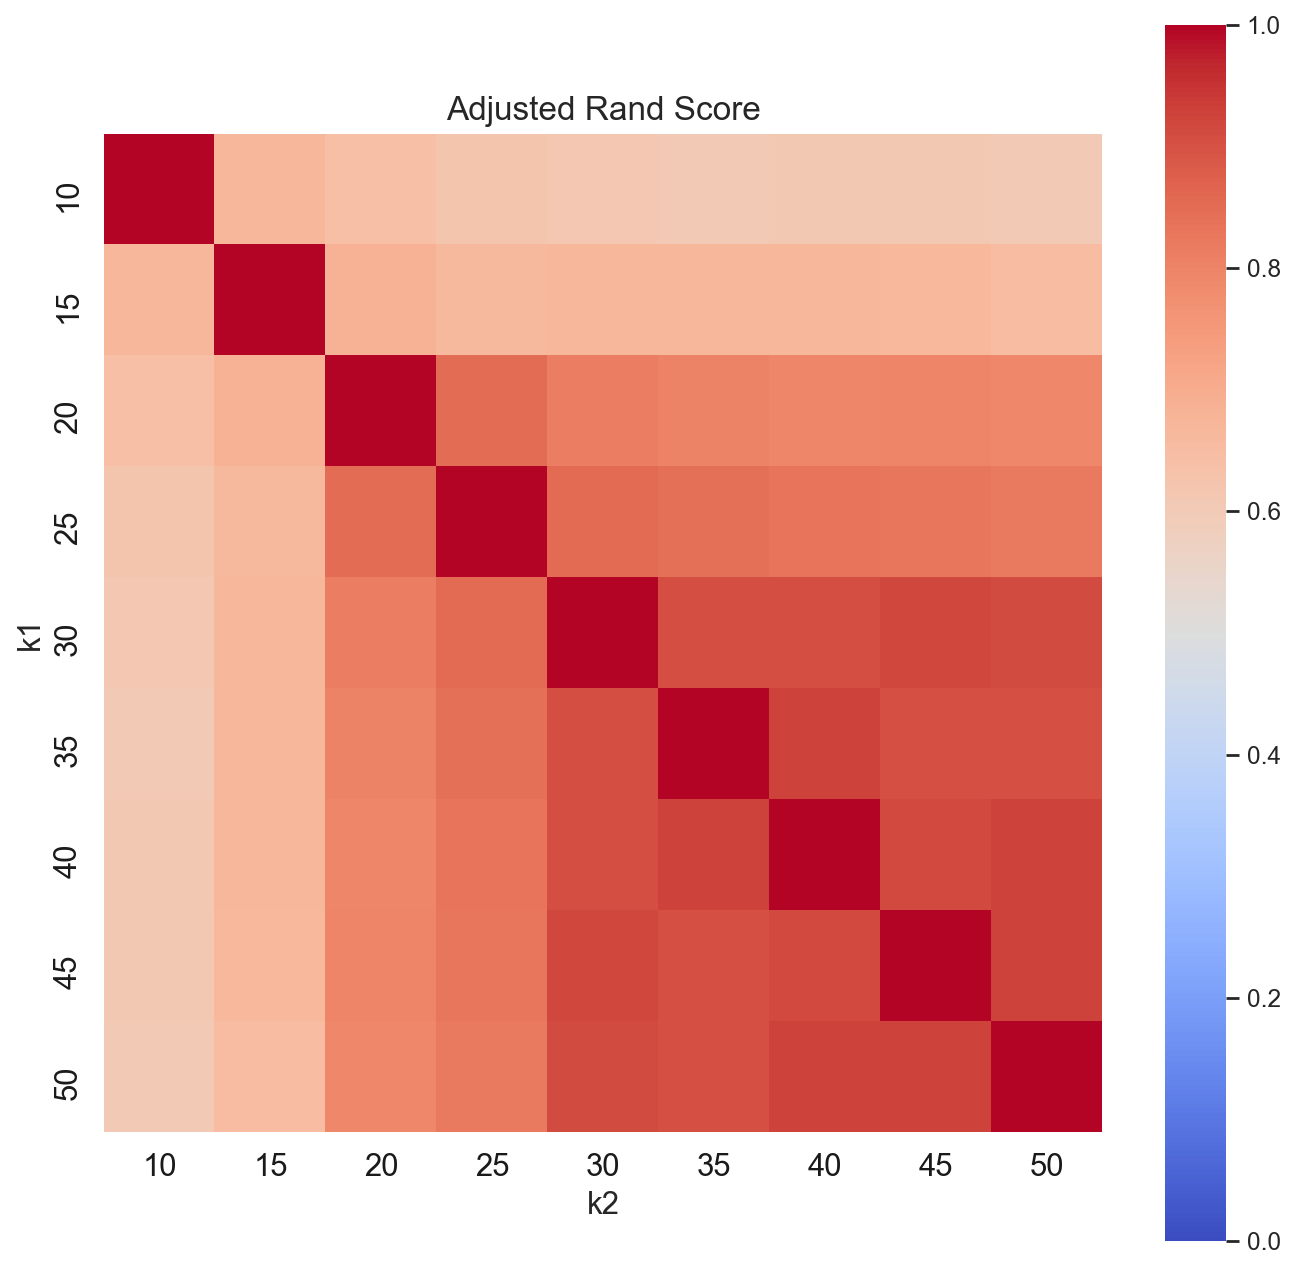

In [23]:
Rand_fig = plt.figure(figsize = (10,10))
plt.xlabel('k1')
plt.ylabel('k2')
plt.title('Adjusted Rand Score',fontsize=15)
sns.set(font_scale=1)
sns.heatmap(Rand_index_df, cmap=('coolwarm'), square=True, vmin=0, vmax=1)
# plt.colorbar(vmin=0)
plt.show();plt.close()


In [24]:
k = 40 # choose k
communities, graph, Q = sc.external.tl.phenograph(pd.DataFrame(adata_exci.obsm['X_pca']),k=k) # run PhenoGraph
adata_exci.obs['PhenoGraph_clusters_exci'] = pd.Categorical(communities)
adata_exci.uns['PhenoGraph_Q'] = Q
adata_exci.uns['PhenoGraph_k'] = k

Finding 40 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.5649621486663818 seconds
Jaccard graph constructed in 1.5443270206451416 seconds
Wrote graph to binary file in 0.8423831462860107 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.801606
Louvain completed 21 runs in 3.275386095046997 seconds
Sorting communities by size, please wait ...
PhenoGraph complete in 6.939393043518066 seconds


## Vizualize Excitatory sub-clusters

... storing 'Condition' as categorical
... storing 'B_region' as categorical


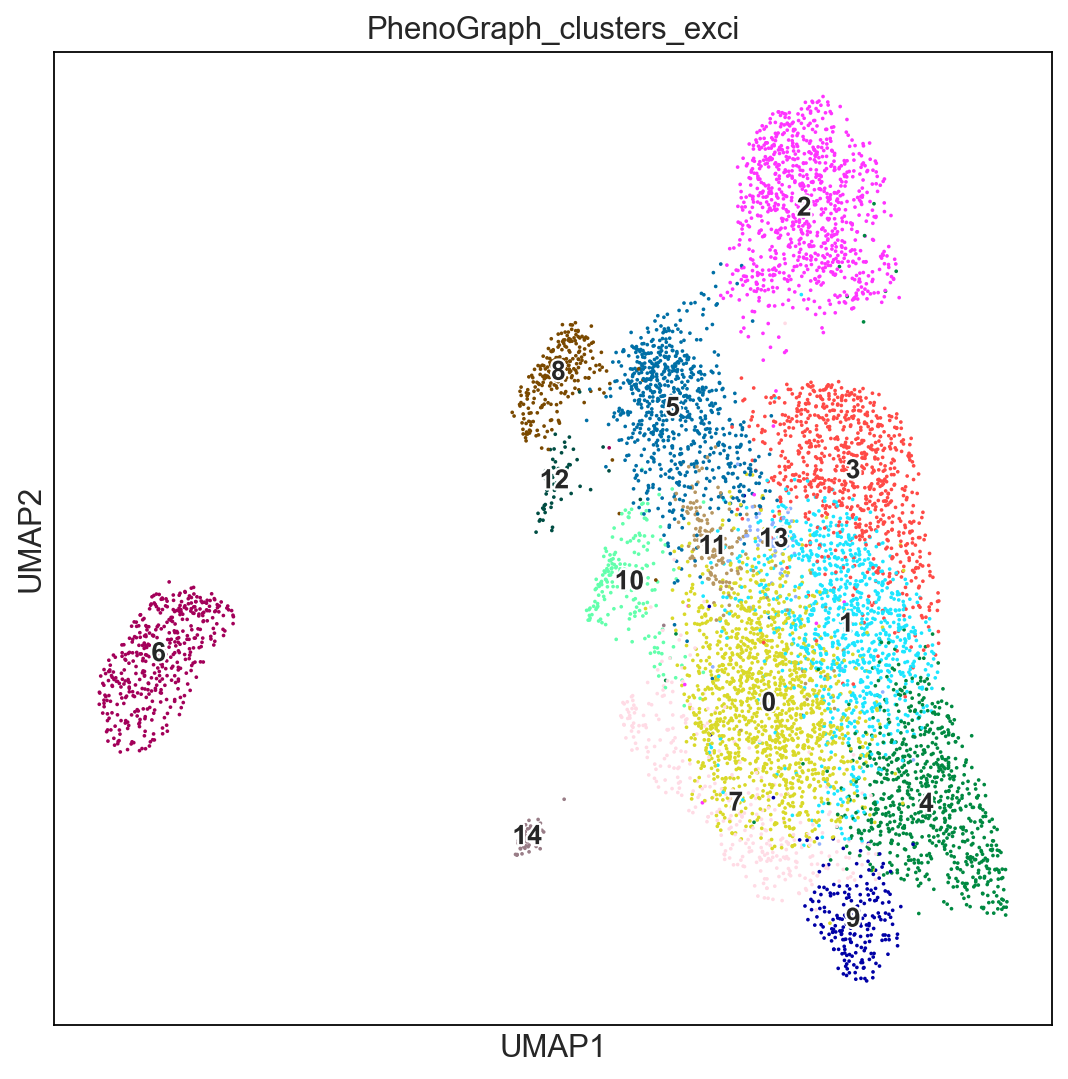

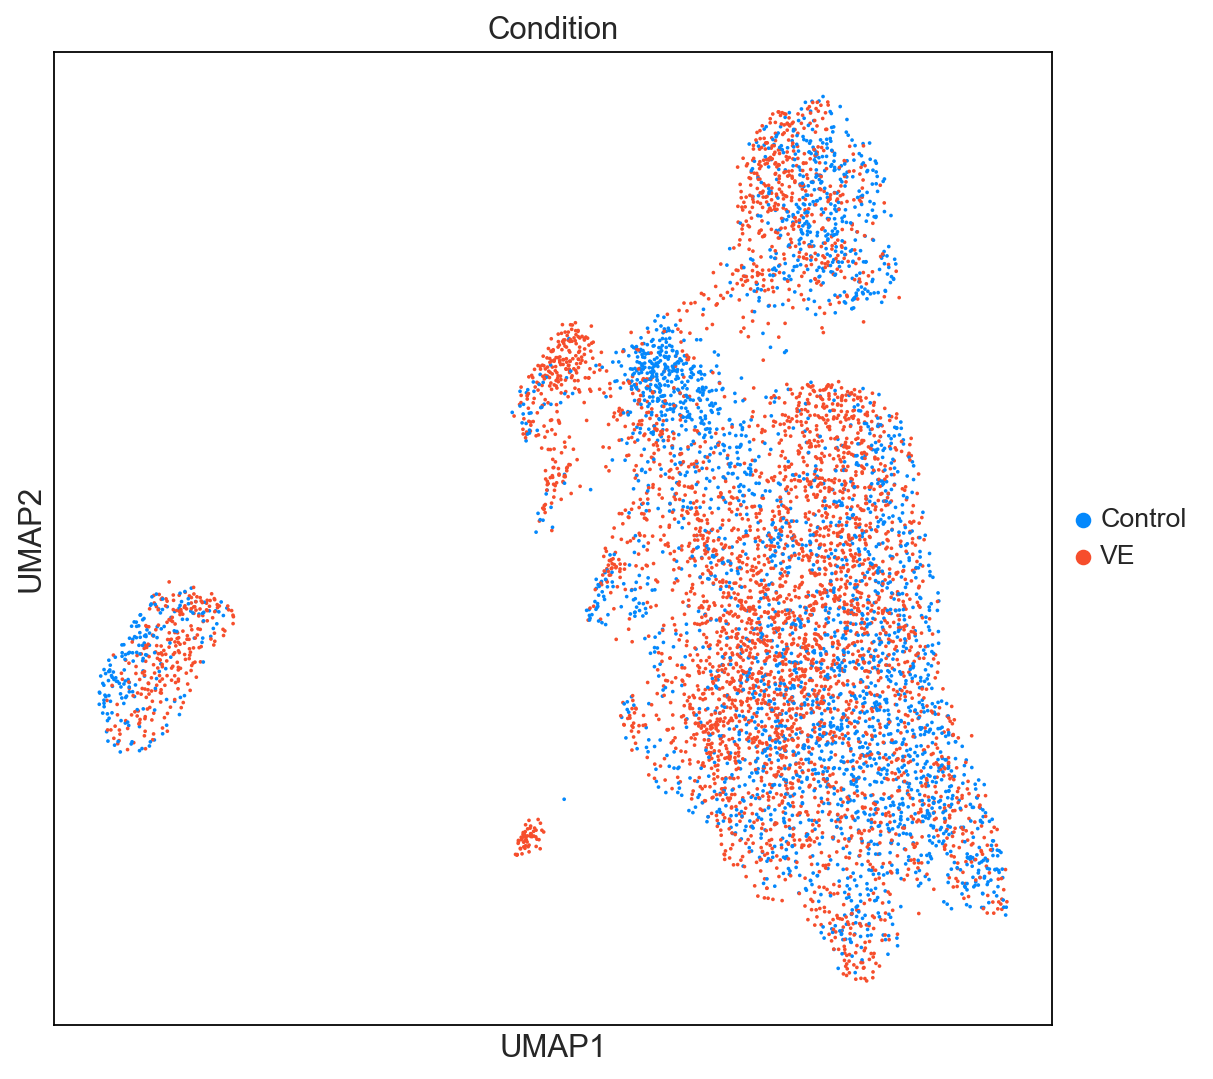

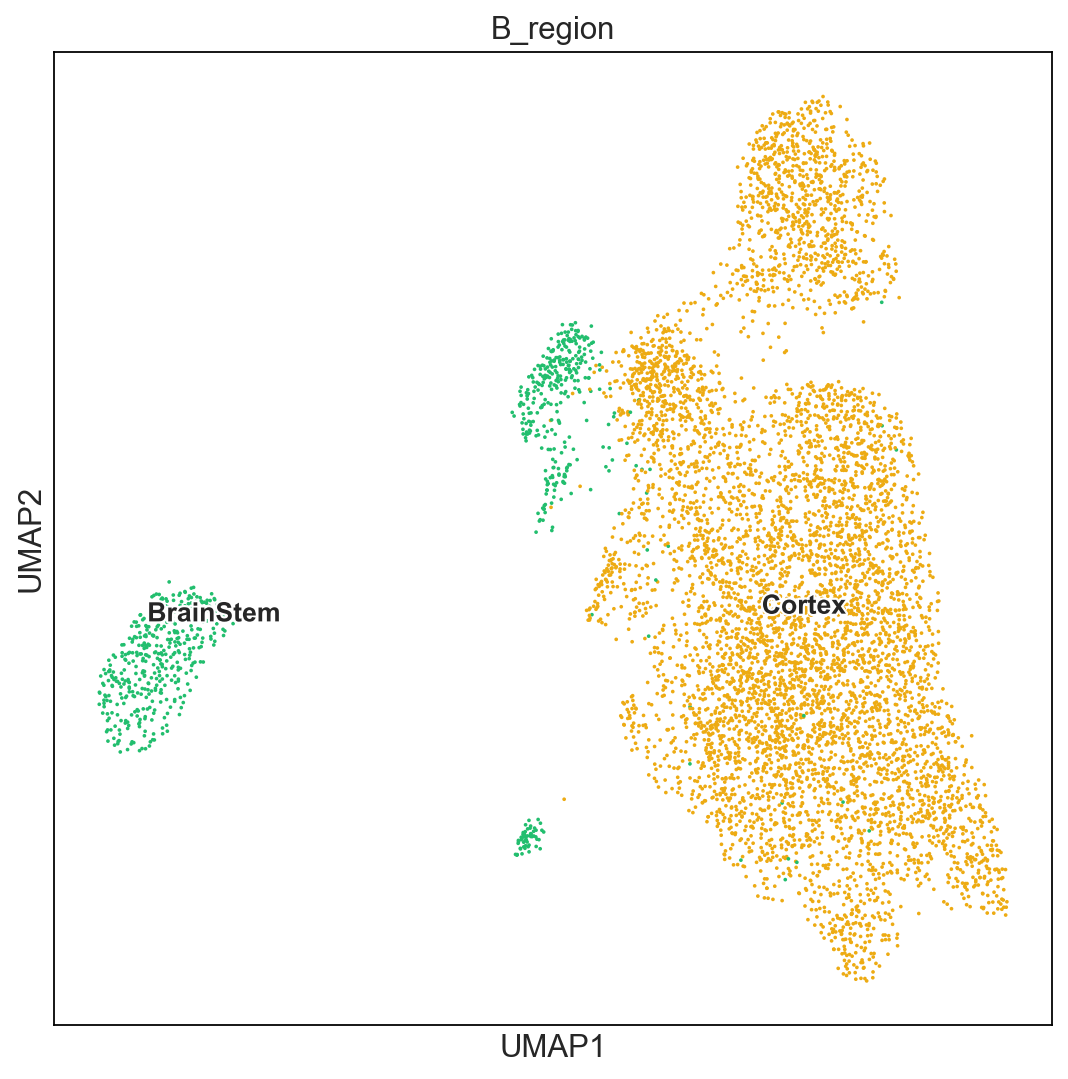

In [25]:
sc.set_figure_params(figsize=(8, 8))
sc.pp.neighbors(adata_exci, method='umap', use_rep='X_pca')
sc.tl.umap(adata_exci, random_state=None)
sc.pl.umap(
    adata_exci,
    color=['PhenoGraph_clusters_exci'],
    ncols=2,
    sort_order=False,
    #edges = True,
    palette=godsnot_64, # 'palette' specifies the colormap to use
    cmap='Spectral_r',
    legend_loc='on data',
    legend_fontsize=12, size = 11,
    legend_fontoutline=2,
    #save= '_immune_cells_PhenoGraph_clusters'
)

sc.pl.umap(
    adata_exci,
    color=['Condition'],
    ncols=2,
    sort_order=False,
    #edges = True,
    palette=['#0488FC','#F64E2C'], # 'palette' specifies the colormap to use
    cmap='Spectral_r',
   # legend_loc='on data',
    legend_fontsize=12, size = 11,
    legend_fontoutline=2,
    #save= '_immune_cells_PhenoGraph_clusters'
)

sc.pl.umap(
    adata_exci,
    color=['B_region'],
    ncols=2,
    sort_order=False,
    #edges = True,
    palette= ["#22BE6E", "#EDAB13"], # 'palette' specifies the colormap to use
    cmap='Spectral_r',
    legend_loc='on data',
    legend_fontsize=12, size = 11,
    legend_fontoutline=2,
    #save= '_immune_cells_PhenoGraph_clusters'
)




## Find markers (Excitatory clusters)

In [26]:
cl_int_to_str = dict()
cl_int_to_str = {
    0 : 'Exc0',
    1 : 'Exc1',
    2 : 'Exc2',
    3 : 'Exc3',
    4 : 'Exc4',
    5 : 'Exc5',
    6 : 'Exc6',
    7 : 'Exc7',
    8 : 'Exc8',
    9 : 'Exc9',
    10 : 'Exc10',
    11 : 'Exc11',
    12 : 'Exc12',
    13 : 'Exc13',
    14 : 'Exc14'}

adata_exci.obs['PhenoGraph_clusters_exci_str'] = adata_exci.obs['PhenoGraph_clusters_exci'].map(cl_int_to_str).astype('category')

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:407: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


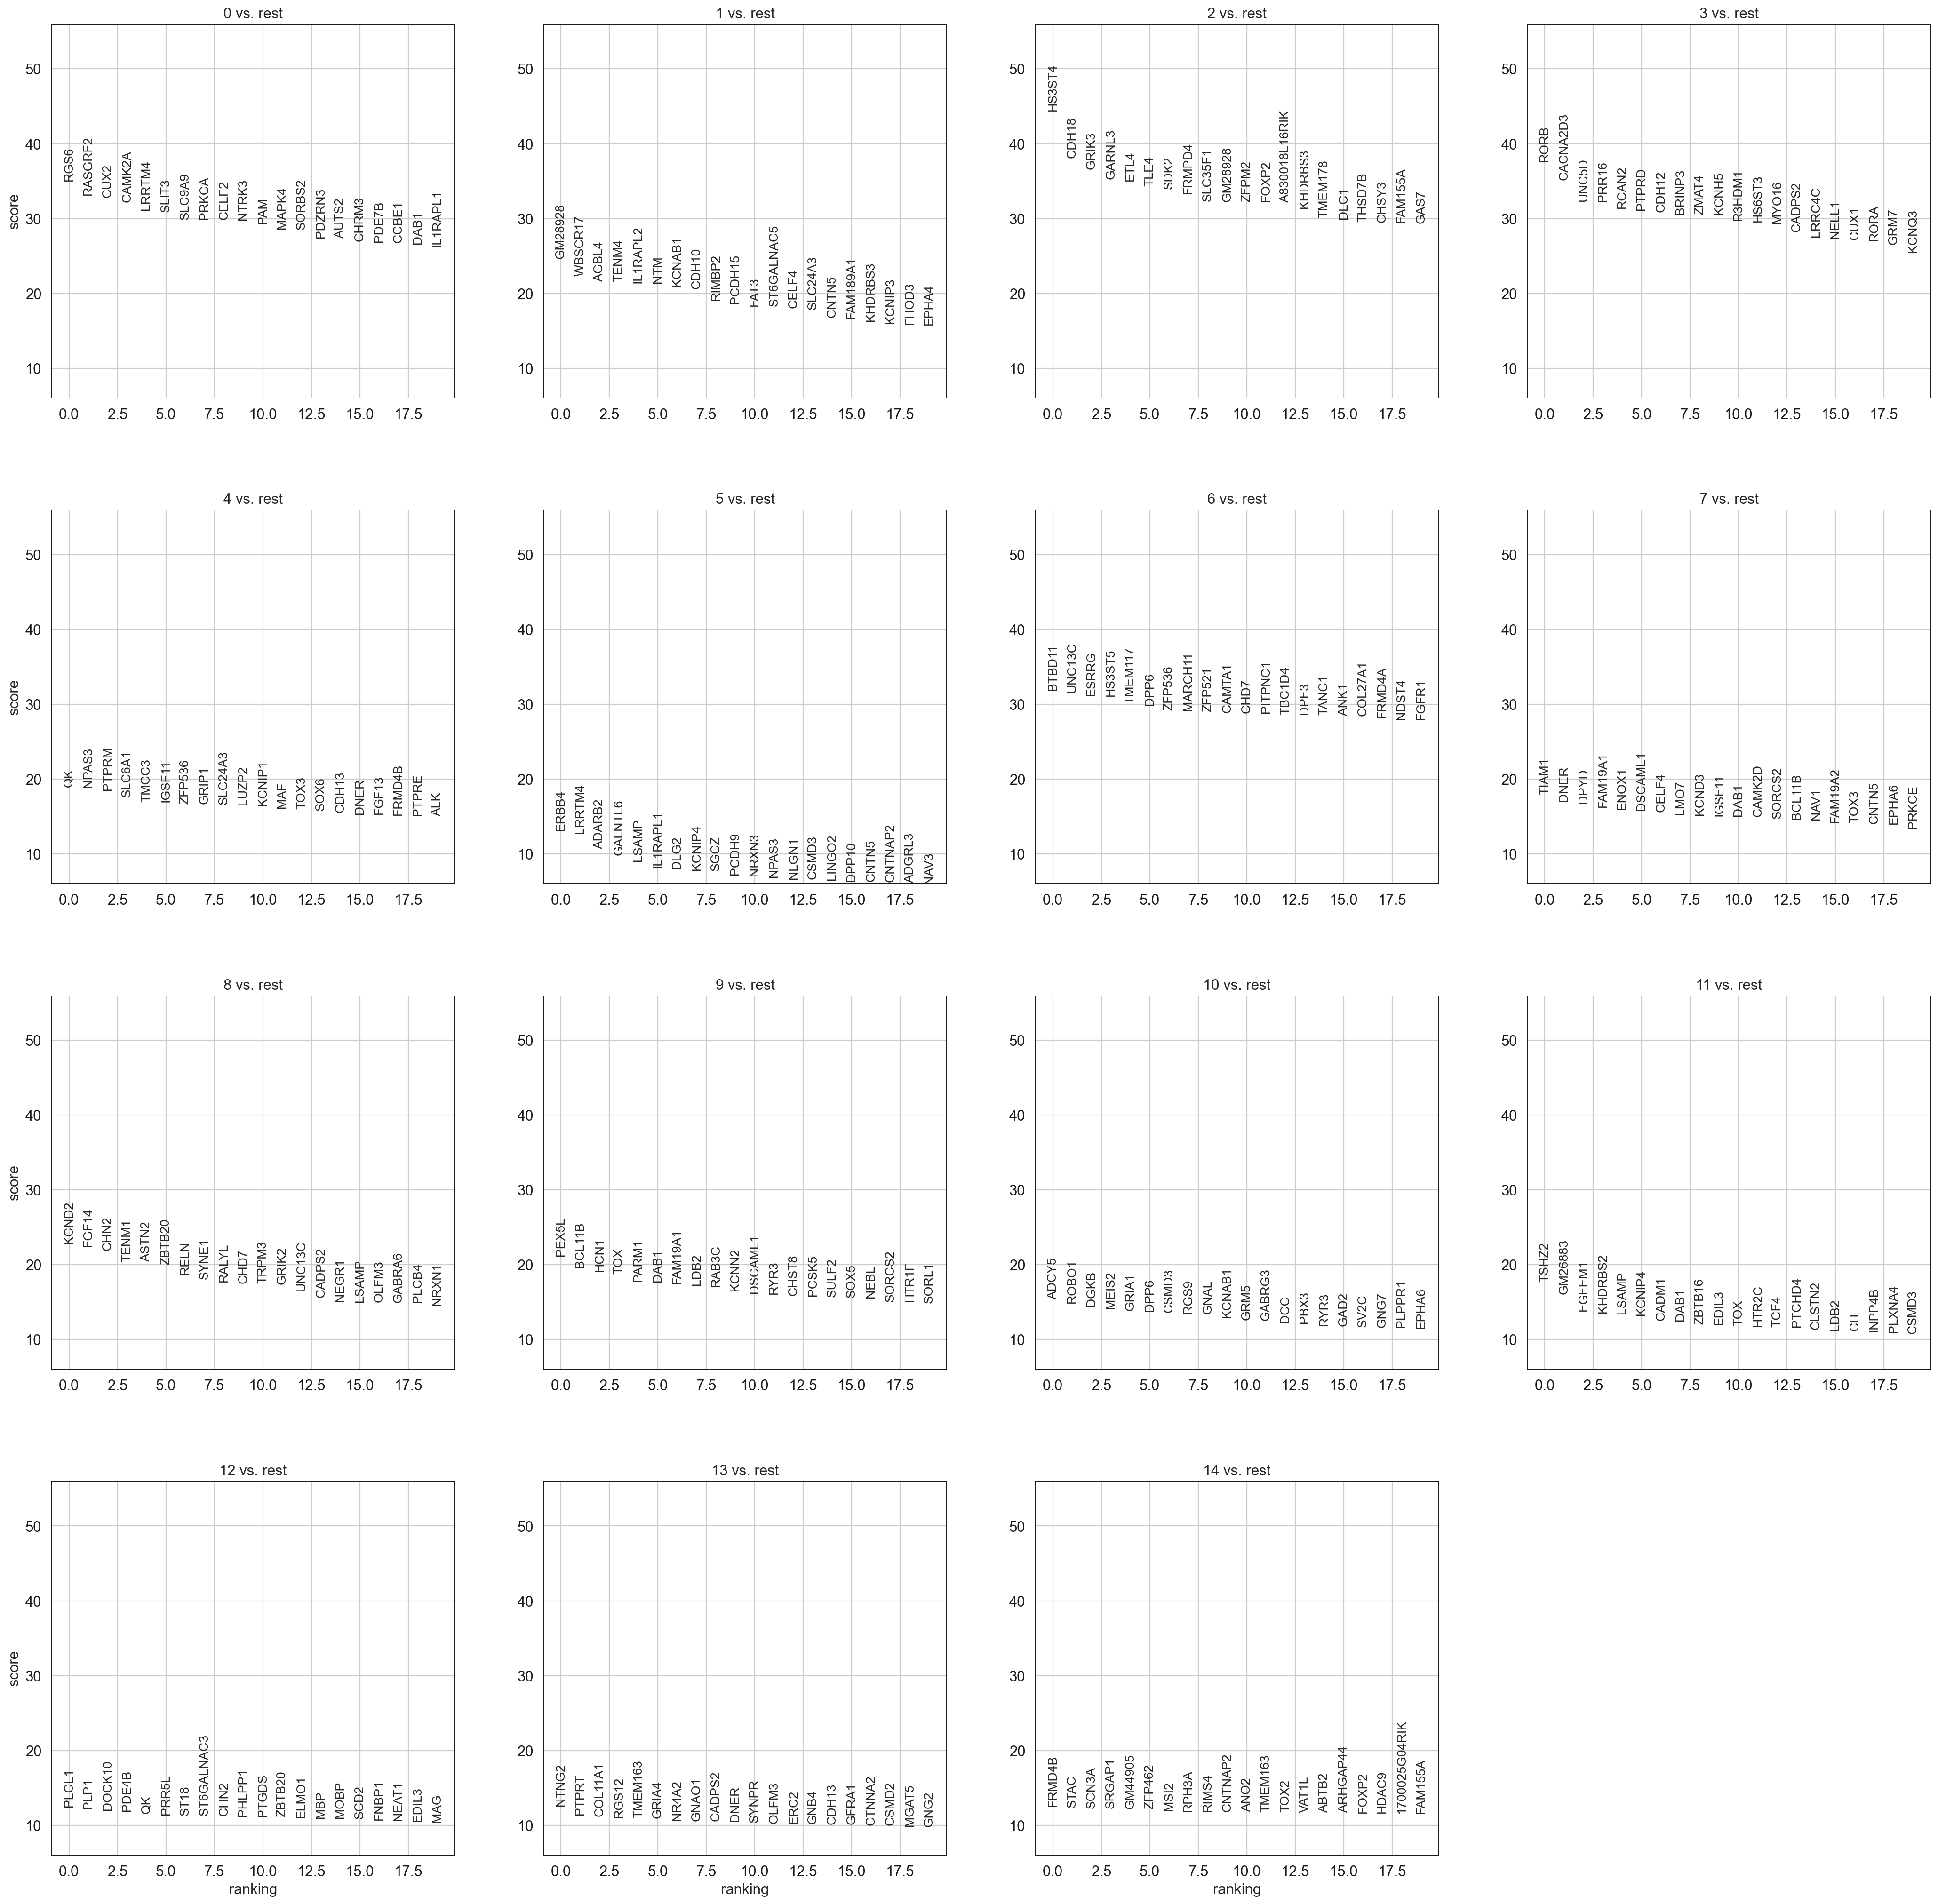

In [27]:
sc.tl.rank_genes_groups(adata_exci, groupby='PhenoGraph_clusters_exci', key_added="ranked_genes_pheno_exci", method='wilcoxon')
sc.pl.rank_genes_groups(adata_exci, key = 'ranked_genes_pheno_exci', fontsize=12)

## Visualize marker genes using heatmap

In [28]:
adata_exci.layers['scaled'] = sc.pp.scale(adata_exci, copy=True).X

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:407: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


{'heatmap_ax': <AxesSubplot:>,
 'groupby_ax': <AxesSubplot:xlabel='PhenoGraph_clusters_exci_str'>,
 'dendrogram_ax': <AxesSubplot:>,
 'gene_groups_ax': <AxesSubplot:>}

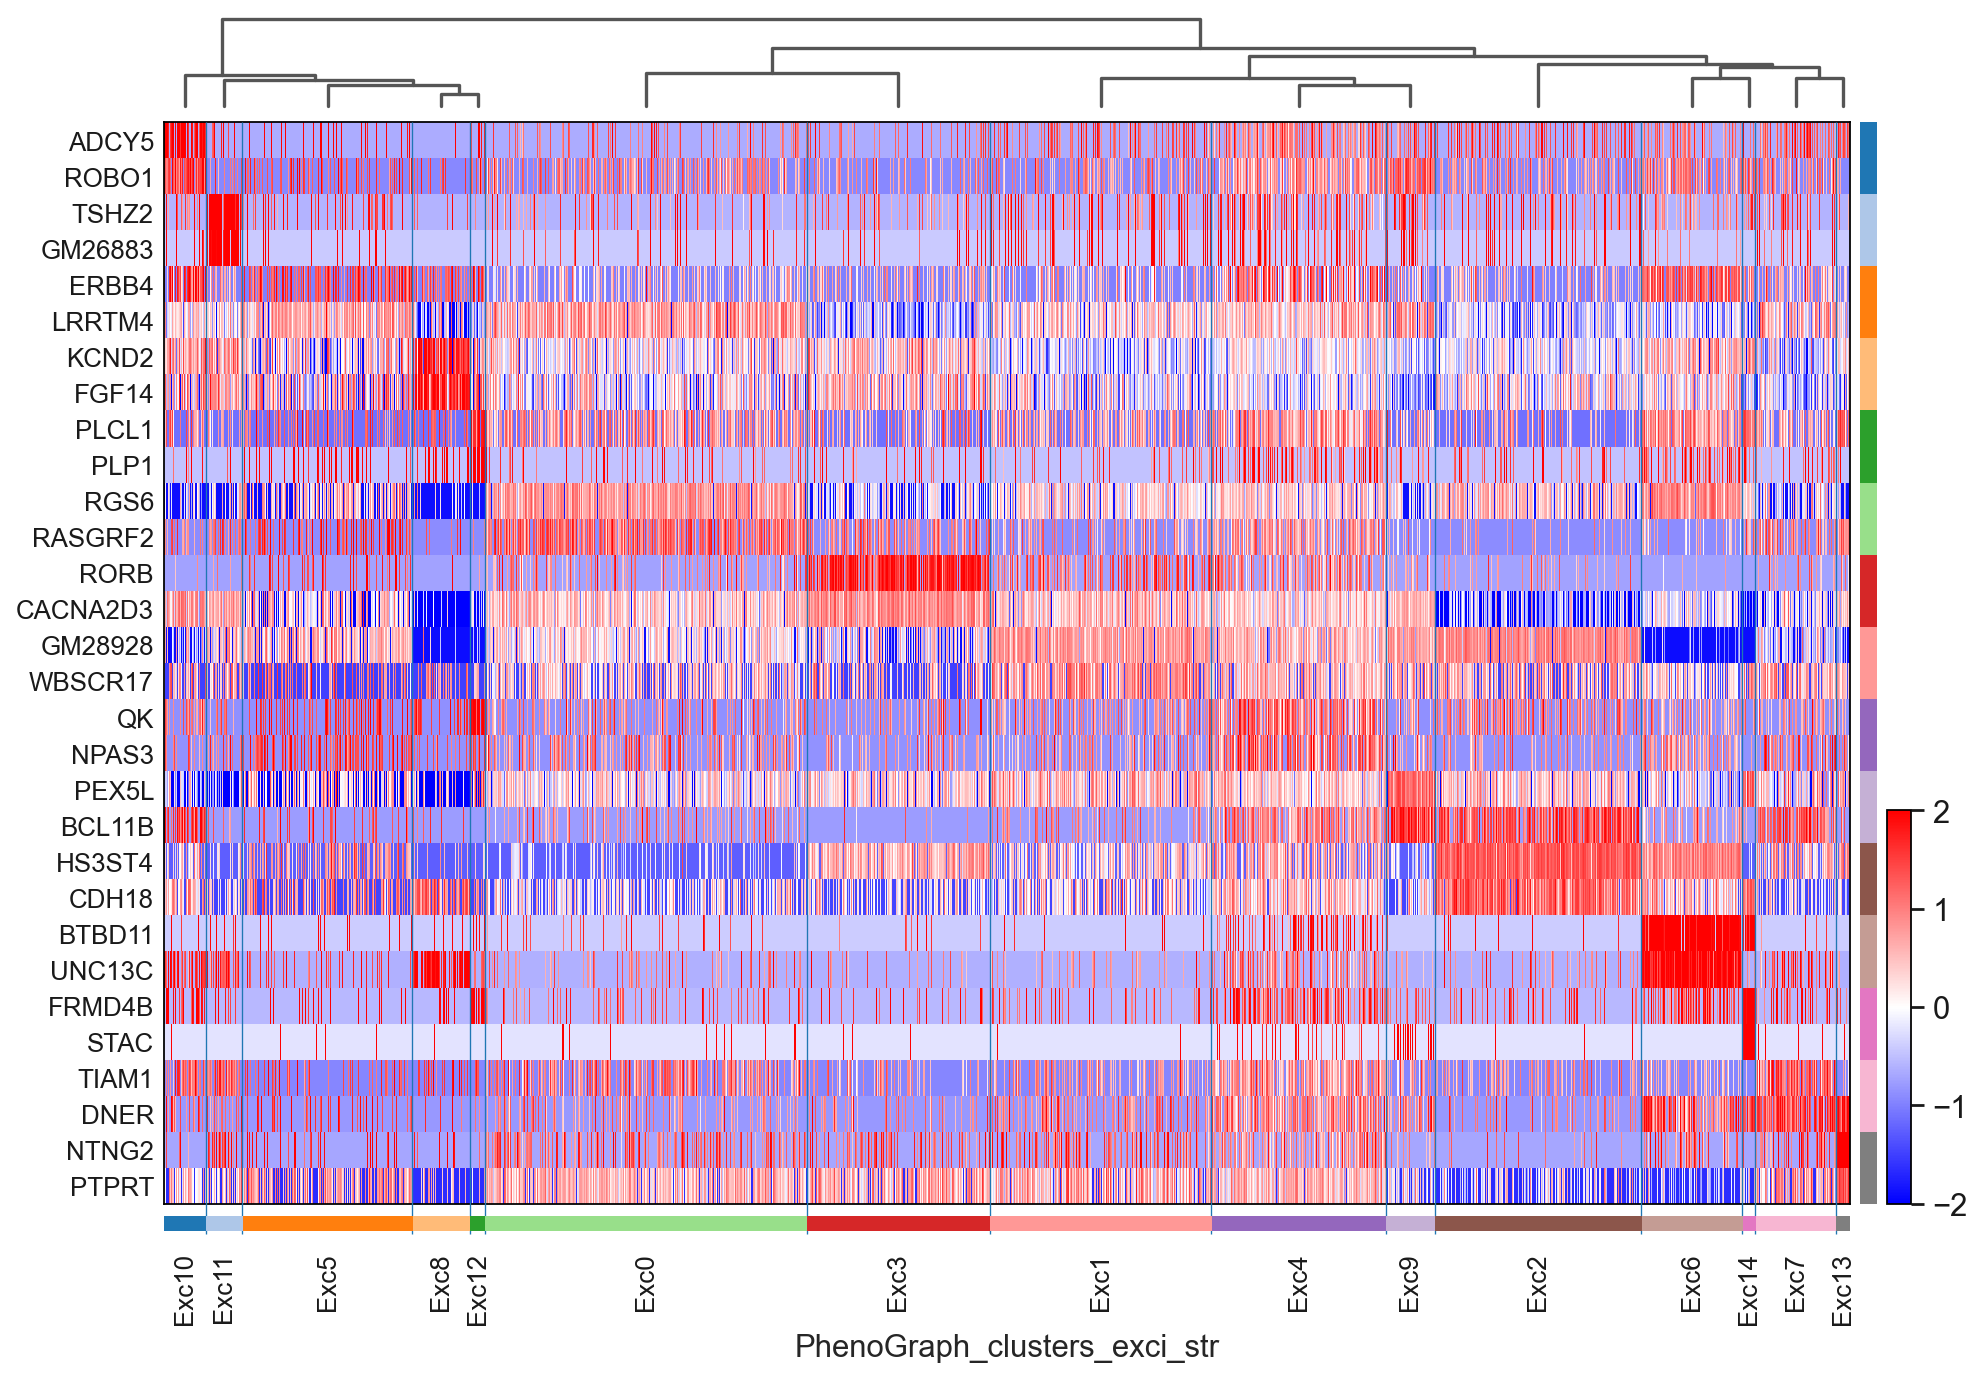

In [30]:
sc.tl.rank_genes_groups(adata_exci, groupby='PhenoGraph_clusters_exci_str', n_genes=adata_exci.shape[1], method='wilcoxon')
sc.pl.rank_genes_groups_heatmap(adata_exci, n_genes=2, use_raw=False, swap_axes=True, vmin=-2, vmax=2, cmap='bwr', layer='scaled', figsize=(14,10), show=False)

## Vizualize known markers

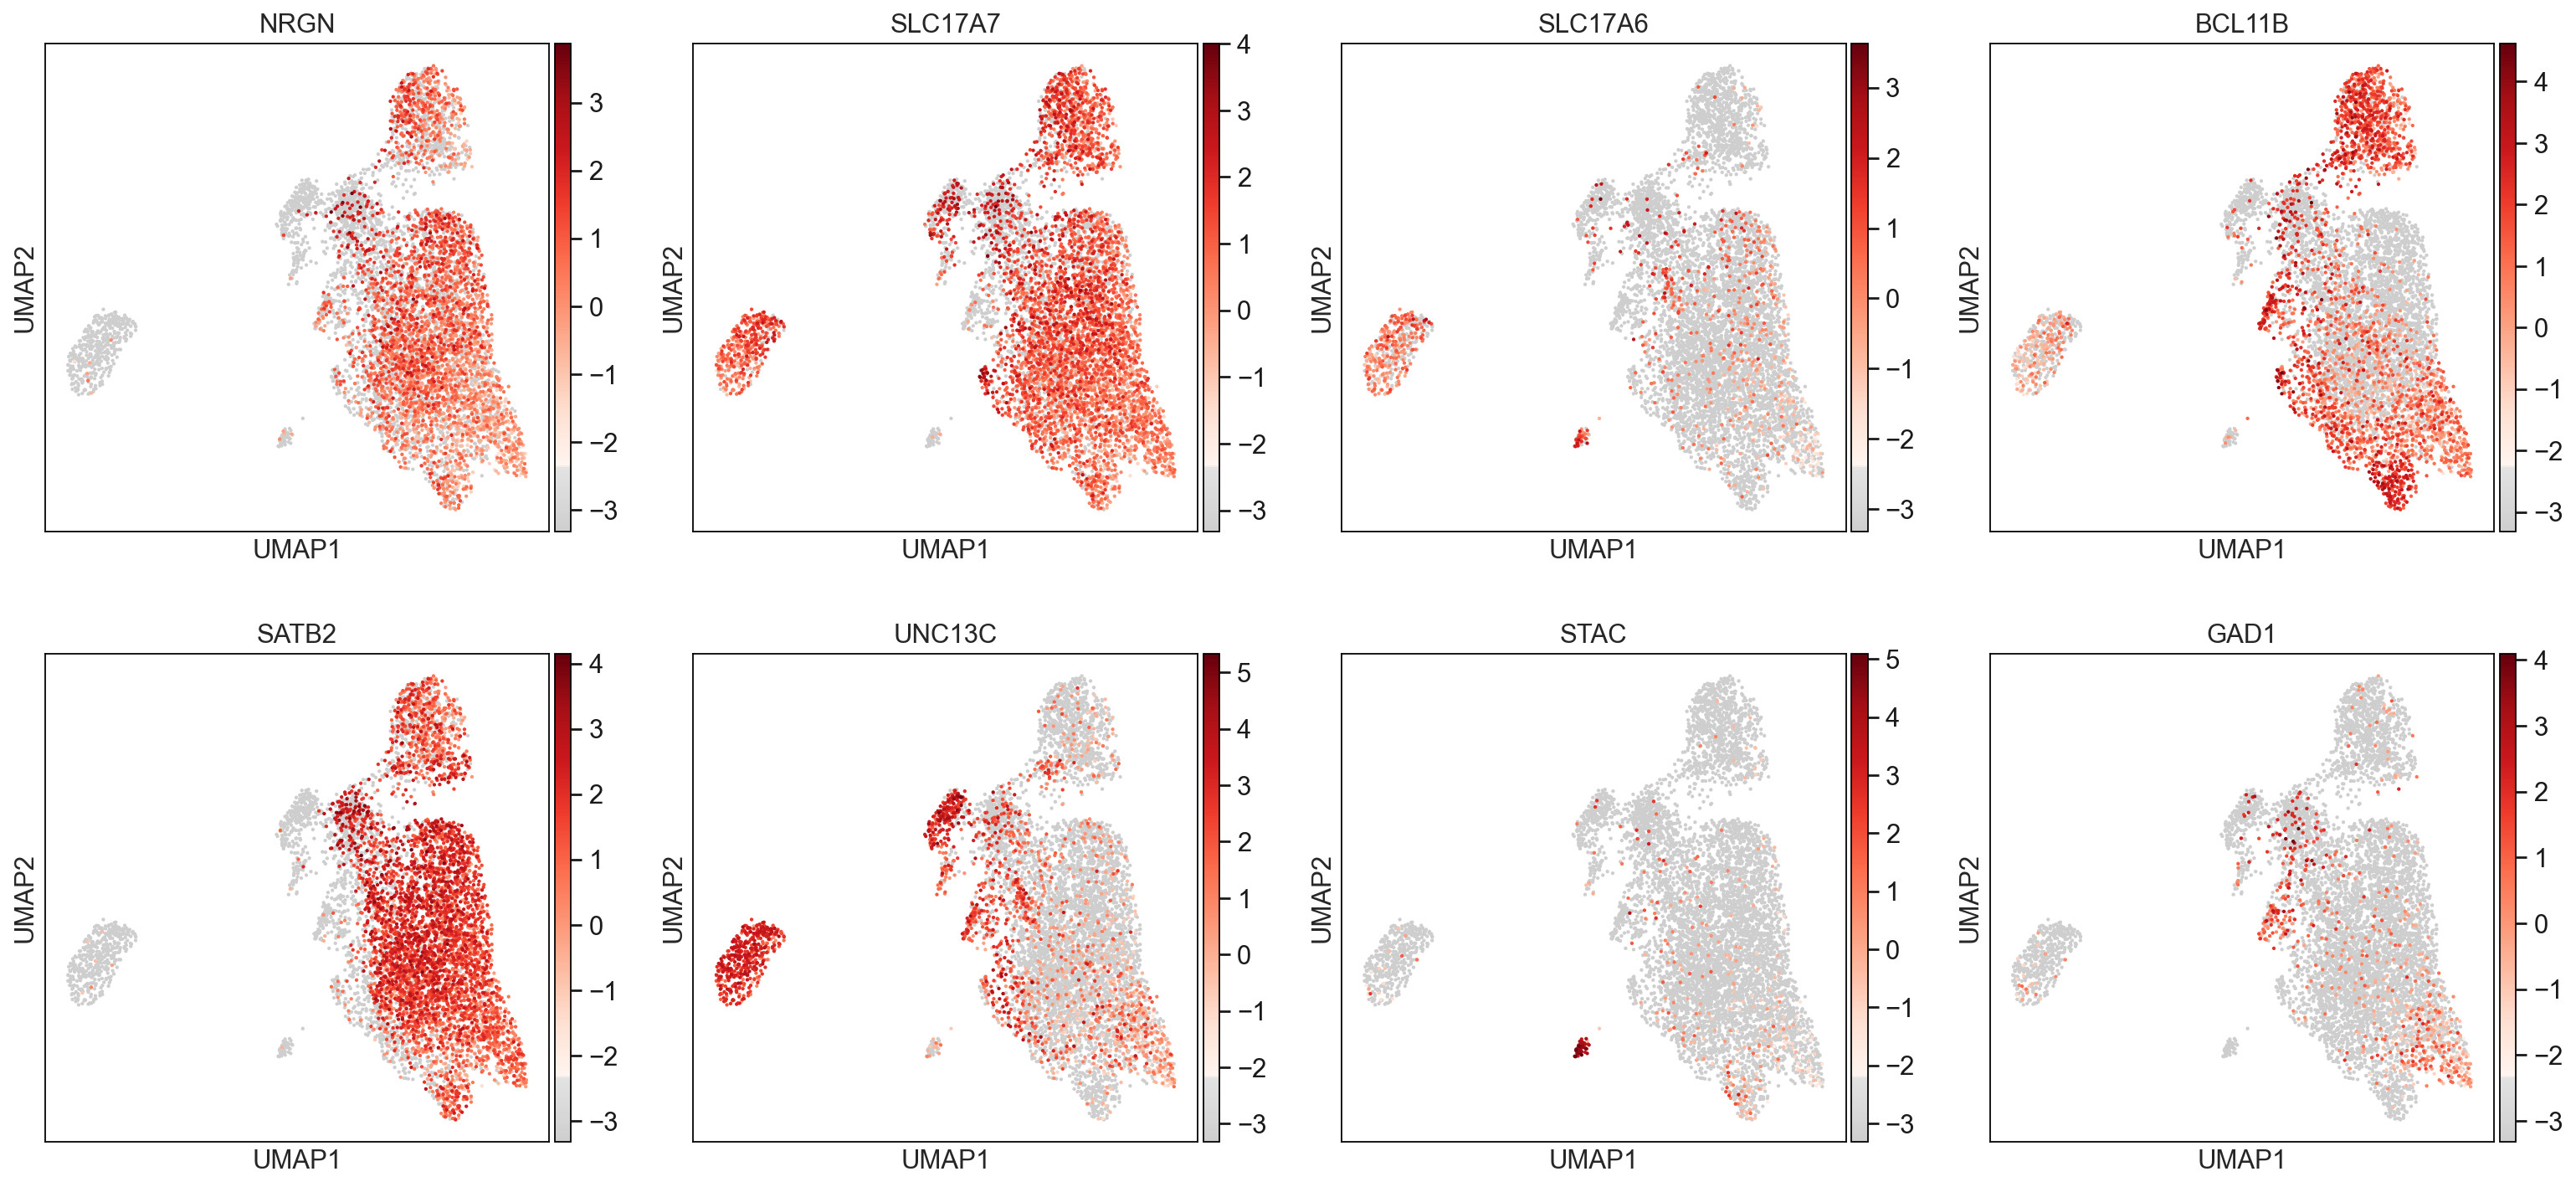

In [42]:
sc.set_figure_params(figsize=(5, 5))
plt.rcParams['figure.figsize'] = [5,5]
#Define a nice colour map for gene expression
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = matplotlib.colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)
 
sc.pl.umap(adata_exci,
           size = 15,
           color=['NRGN','SLC17A7','SLC17A6','BCL11B','SATB2', 'UNC13C', 'STAC', 'GAD1'],
           color_map=mymap)

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/scanpy/plotting/_matrixplot.py:222: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  __ = ax.pcolor(_color_df, **kwds)


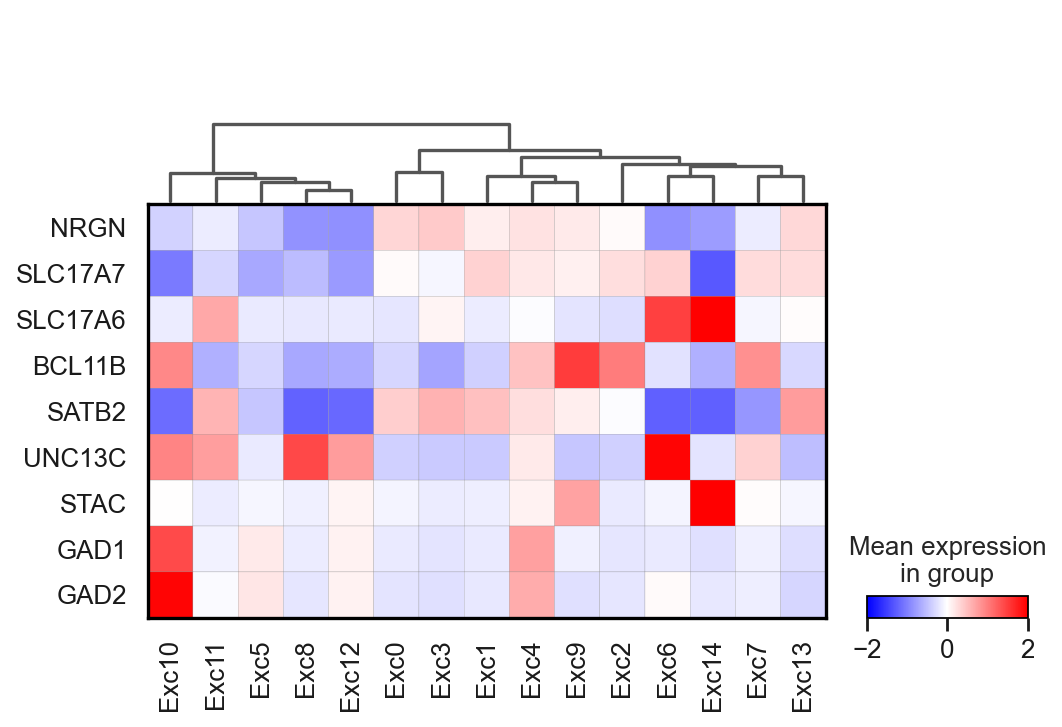

In [41]:
sc.pl.matrixplot(adata_exci, ['NRGN','SLC17A7','SLC17A6','BCL11B','SATB2', 'UNC13C', 'STAC','GAD1','GAD2'], groupby='PhenoGraph_clusters_exci_str', 
               use_raw=False, vmin=-2, vmax=2, cmap='bwr', layer='scaled'
            ,dendrogram=True,swap_axes=True)

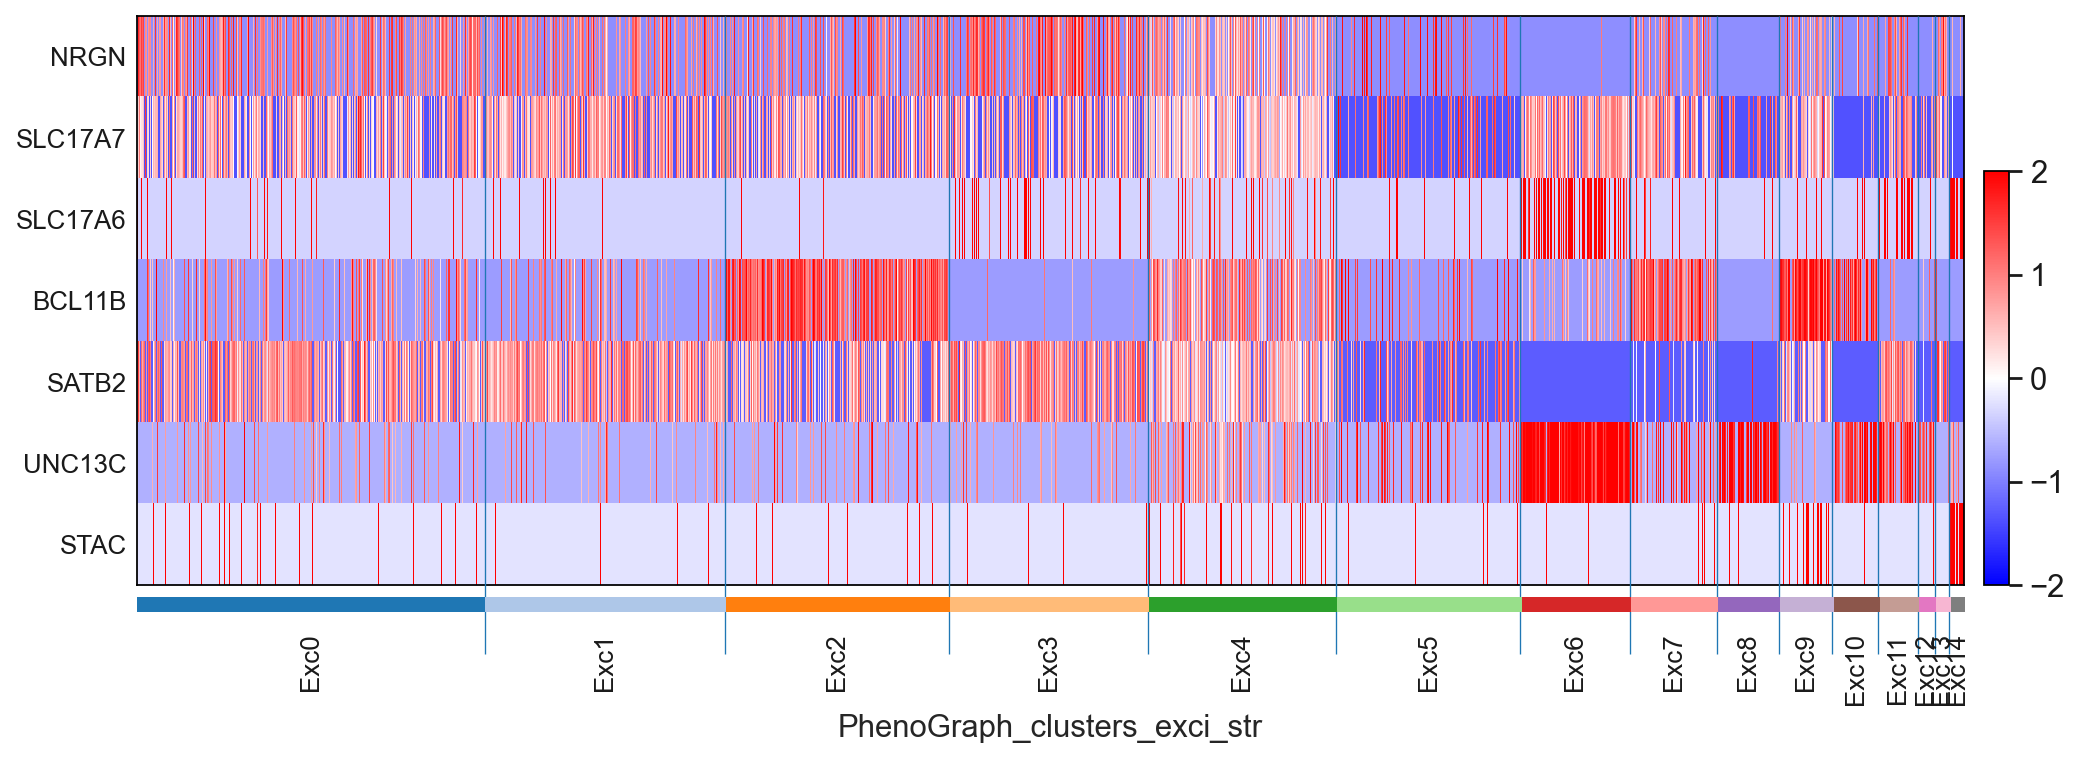

In [34]:
sc.pl.heatmap(adata_exci, ['NRGN','SLC17A7','SLC17A6','BCL11B','SATB2', 'UNC13C', 'STAC'], groupby='PhenoGraph_clusters_exci_str', 
               use_raw=False, vmin=-2, vmax=2, cmap='bwr', layer='scaled'
            ,dendrogram=False,swap_axes=True,figsize=(15,5))

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


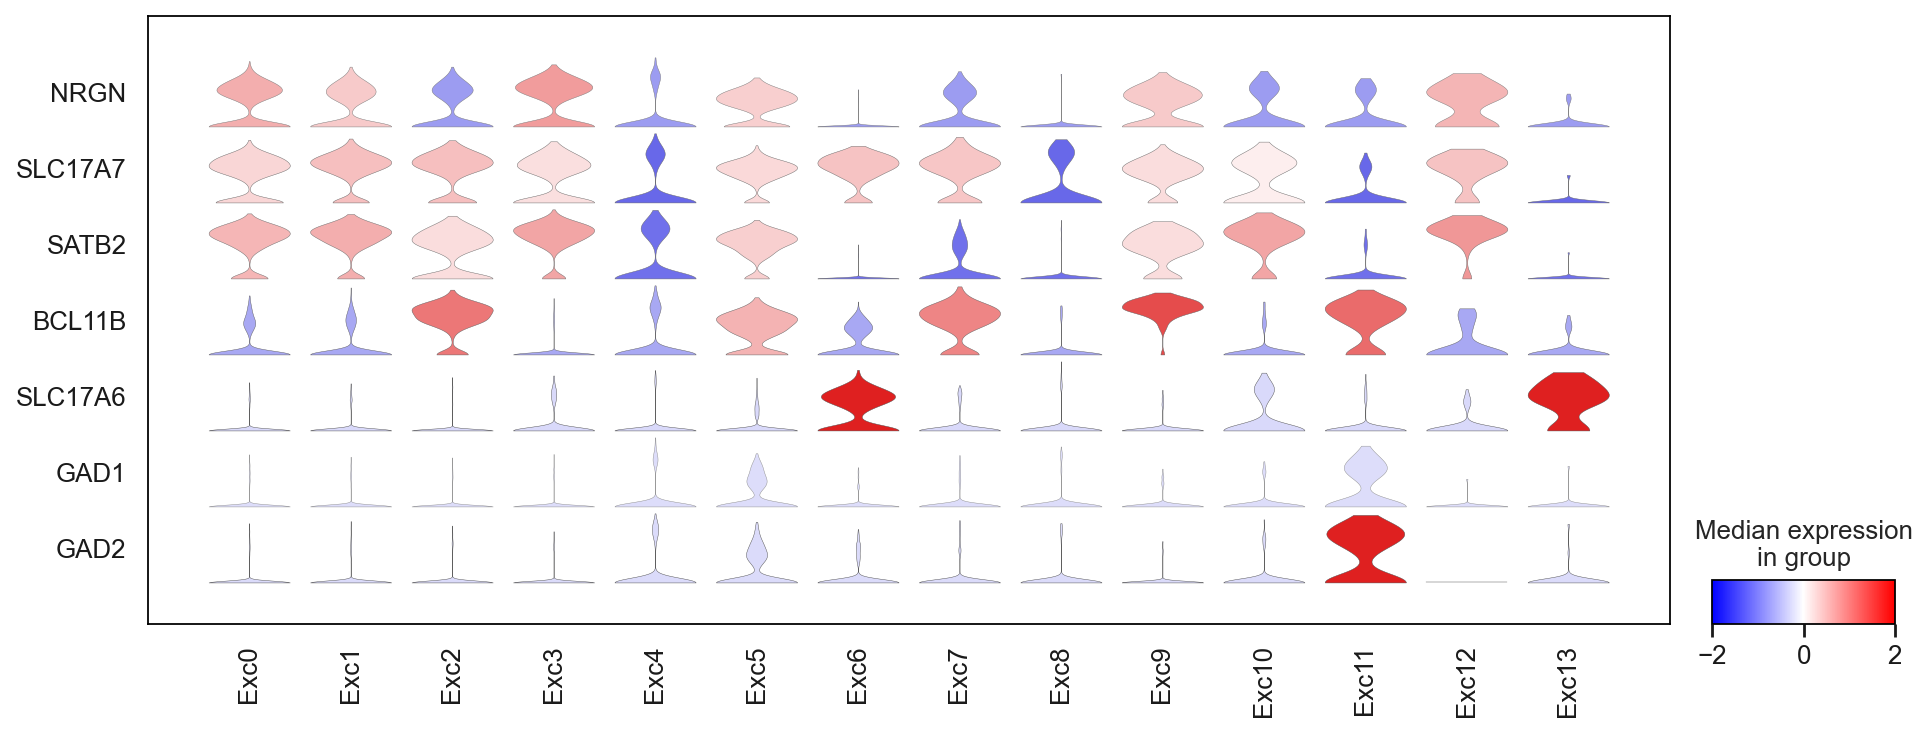

In [141]:
sc.pl.stacked_violin(adata_exci, ['NRGN','SLC17A7','SATB2','BCL11B','SLC17A6','GAD1','GAD2'], groupby='PhenoGraph_clusters_exci_str', swap_axes=True, figsize=[14,5], layer= 'scaled',
                    vmin=-2, vmax=2,dendrogram=False, cmap='bwr')


### Excitatory markers from Lake et al.
(Neuronal subtypes and diversity revealed by single-nucleus RNA sequencing of the human brain)

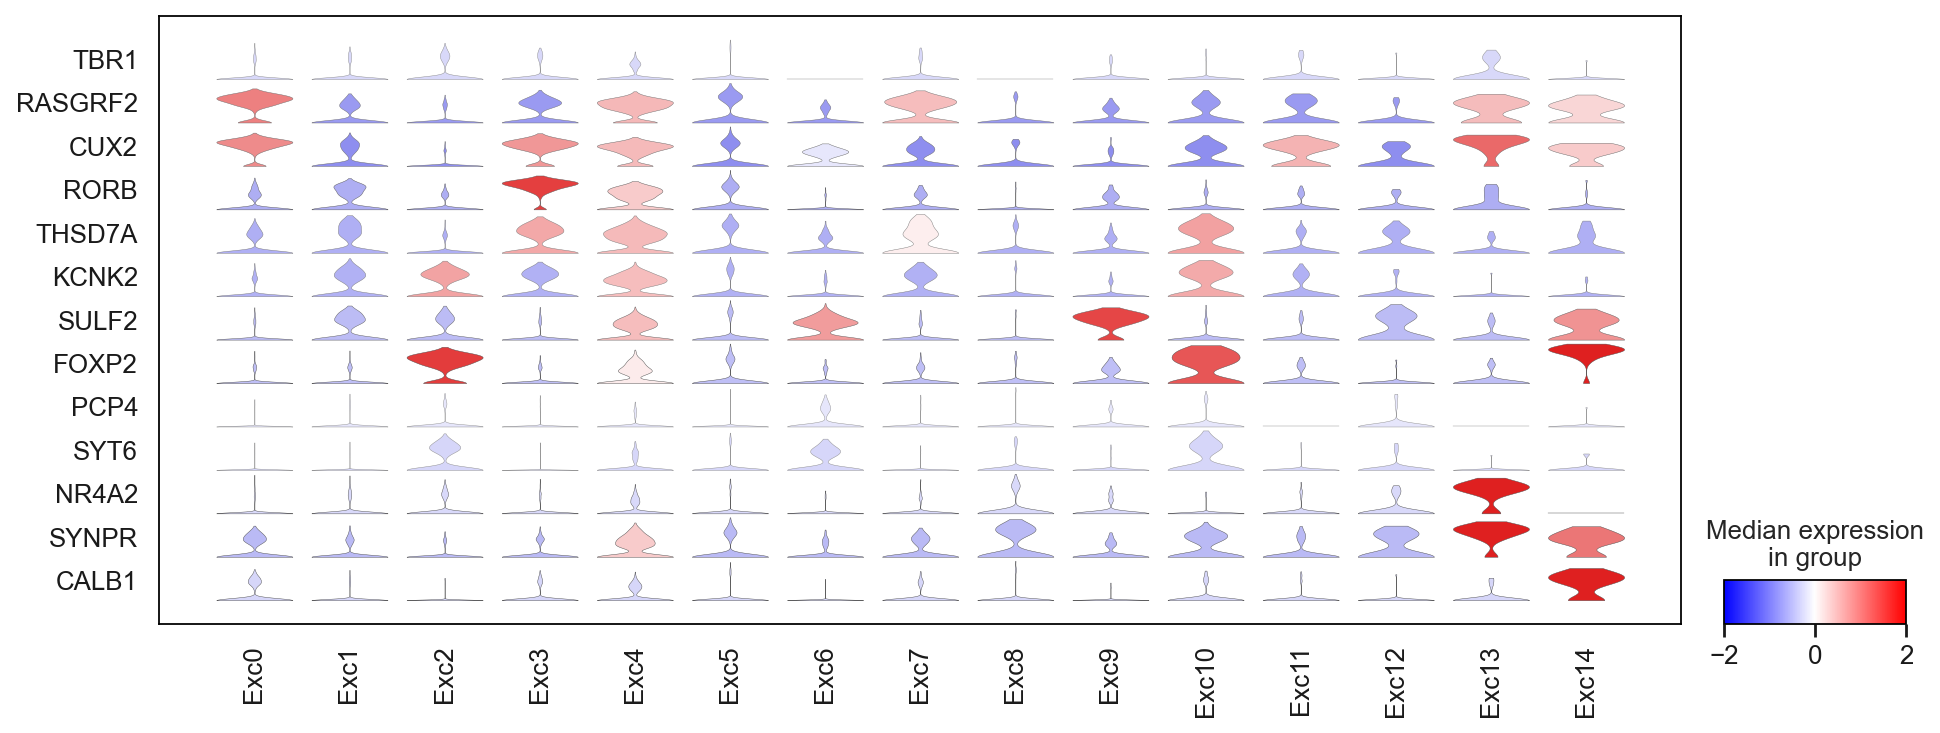

In [36]:
sc.pl.stacked_violin(adata_exci, ['TBR1','RASGRF2','CUX2','RORB','THSD7A','KCNK2','SULF2','FOXP2','PCP4',
                                 'SYT6','NR4A2','SYNPR','CALB1'], groupby='PhenoGraph_clusters_exci_str', swap_axes=True, figsize=[14,5], layer= 'scaled',
                    vmin=-2, vmax=2,dendrogram=False, cmap='bwr')

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


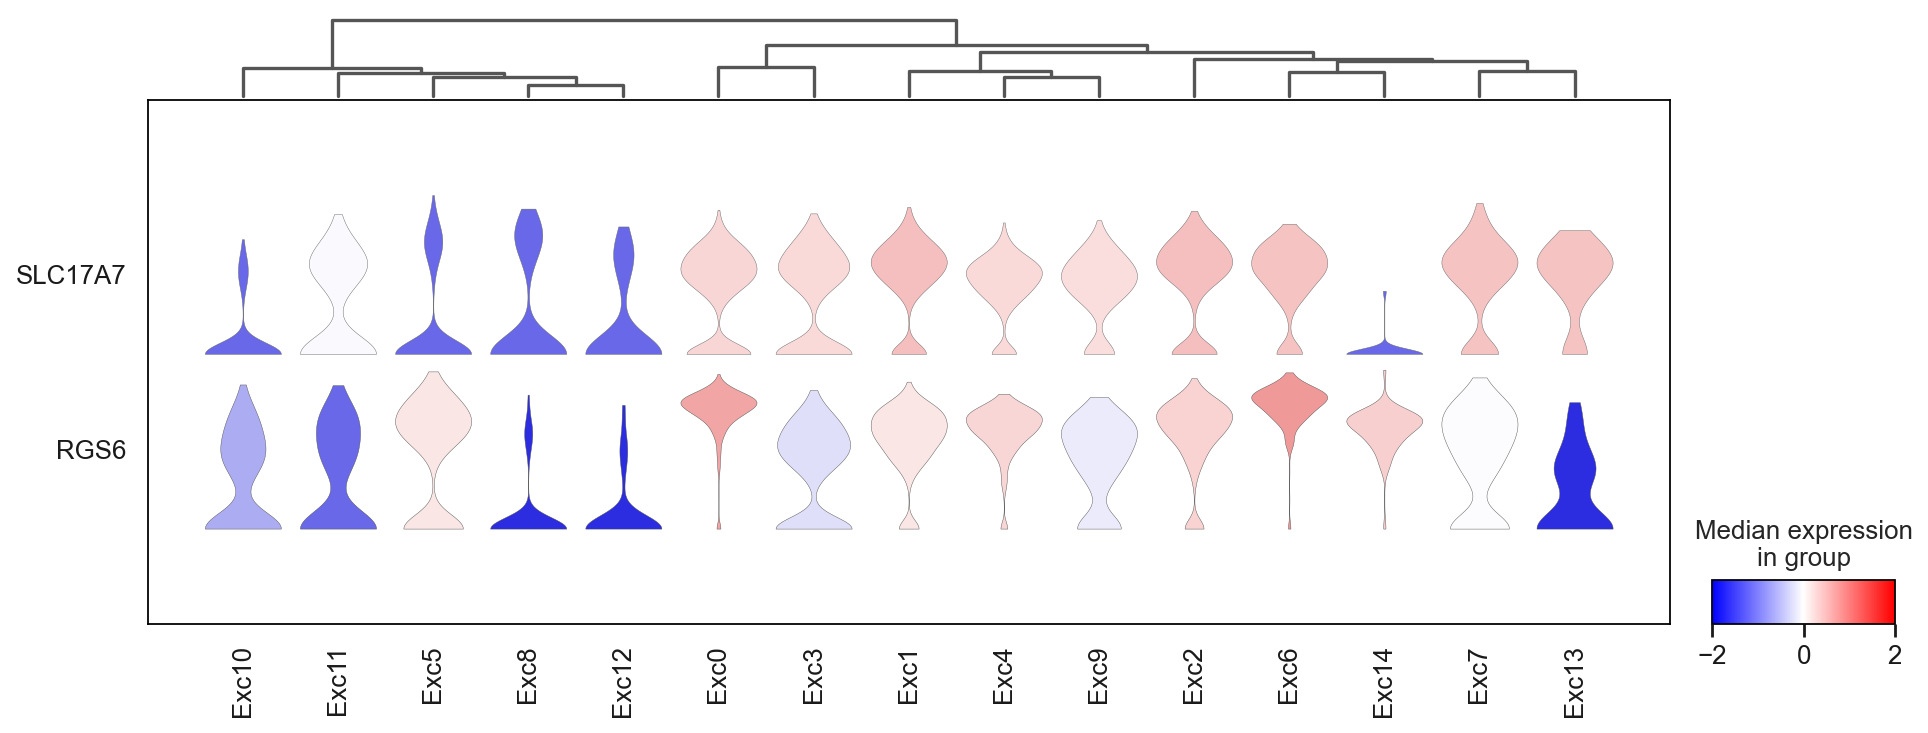

In [37]:
sc.pl.stacked_violin(adata_exci, ['SLC17A7','RGS6'], groupby='PhenoGraph_clusters_exci_str', swap_axes=True, figsize=[14,5], layer= 'scaled',
                    vmin=-2, vmax=2,dendrogram=True, cmap='bwr')

## Save result Adata excitatory neurons

In [38]:
#adata_exci.write_h5ad(outdir+'adata_high_var_excitatory_clusters.h5ad')

In [9]:
adata_exci = sc.read_h5ad(outdir+'adata_high_var_excitatory_clusters.h5ad')

## Excitatory Brainstem

In [43]:
adata_exci_BS = adata_exci.copy()
adata_exci_BS = adata_exci_BS[adata_exci_BS.obs['B_region'].isin(['BrainStem']),:]
adata_exci_BS.shape

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(816, 17054)

In [44]:
adata_exci_BS.obs.Condition.value_counts()

VE         588
Control    228
Name: Condition, dtype: int64

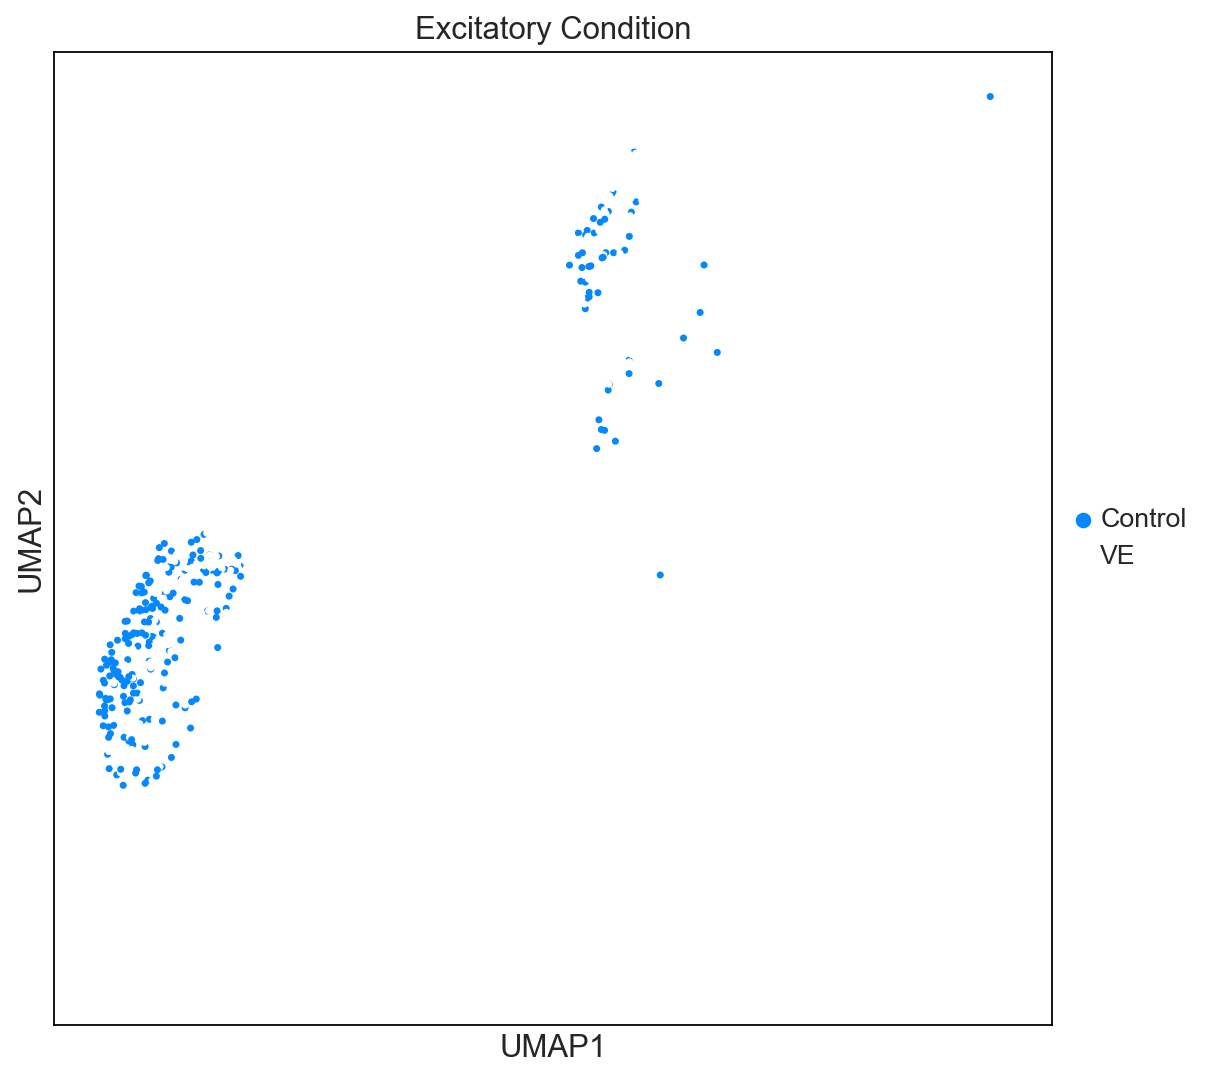

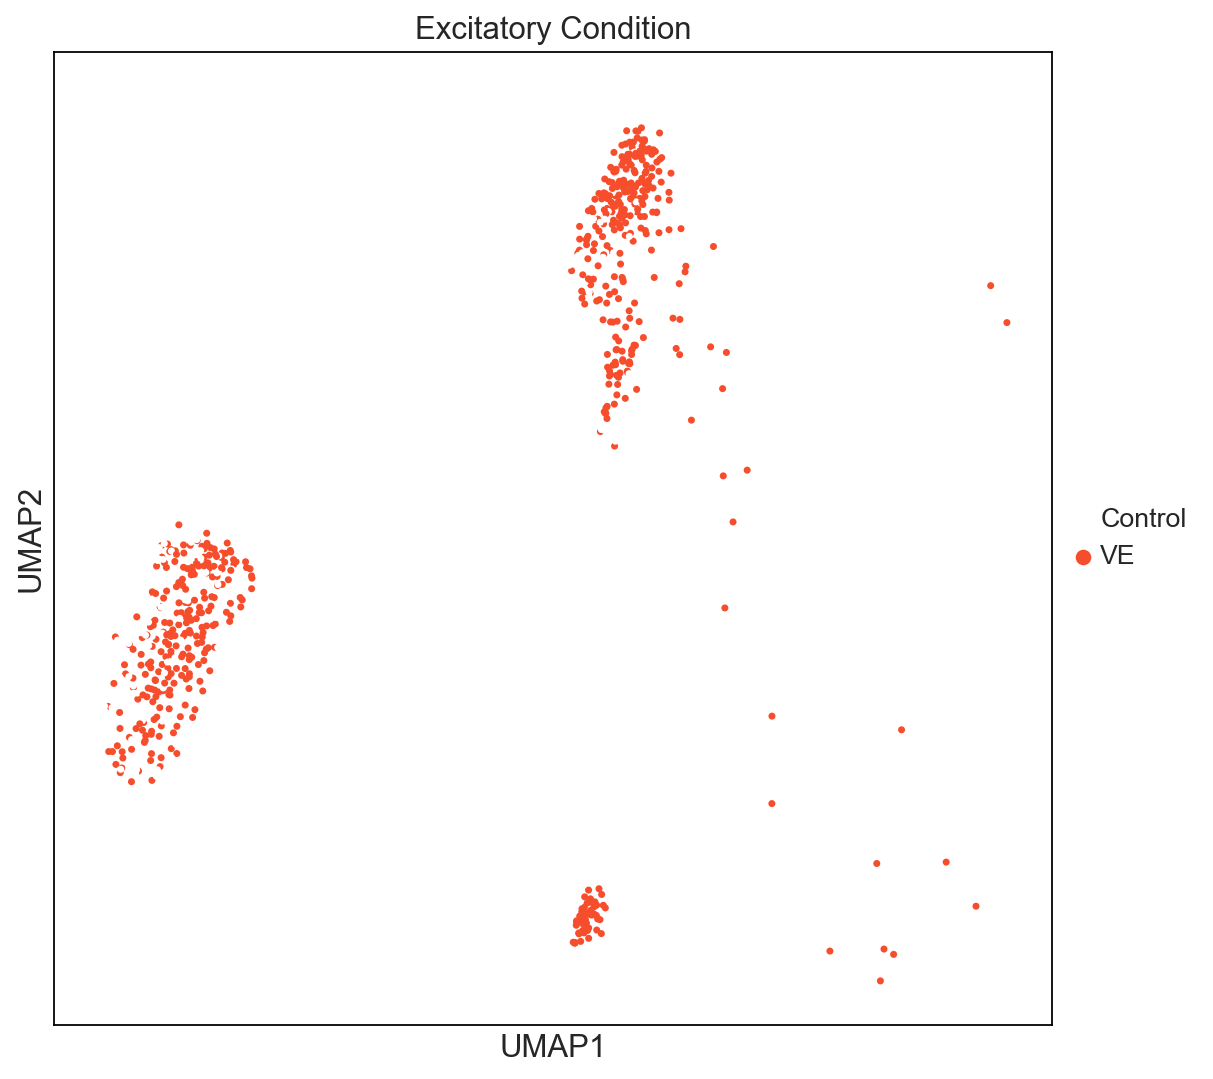

In [46]:
sc.set_figure_params(figsize=(8, 8))
sc.pl.umap(adata_exci_BS, 
           color= ['Condition'],
           ncols=2,
           edges = False,
           edges_width= 0.01,
           palette=['#0488FC','#FFFFFFFF'],
           size=40, 
           #legend_loc='on data', 
           legend_fontsize=12,
           legend_fontoutline=2,
           title=["Excitatory Condition"])


sc.pl.umap(adata_exci_BS, 
           color= ['Condition'],
           ncols=2,
           edges = False,
           edges_width= 0.01,
           palette=['#FFFFFFFF','#F64E2C'],
           size=40, 
           #legend_loc='on data', 
           legend_fontsize=12,
           legend_fontoutline=2,
           title=["Excitatory Condition"])

### Excitatory BS control 

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


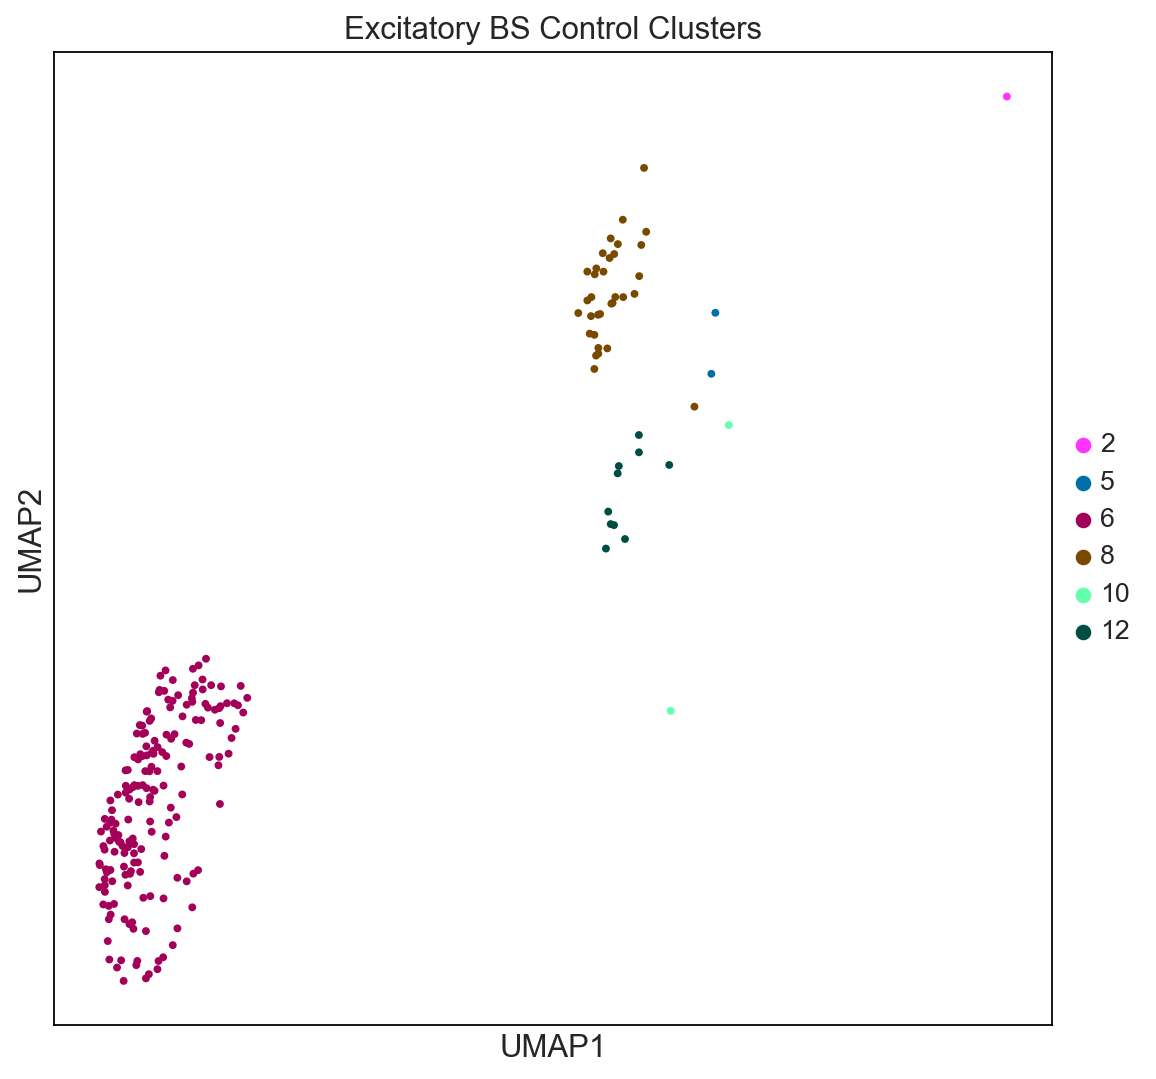

In [76]:
adata_exci_BS_control = adata_exci_BS[adata_exci_BS.obs['Condition'].isin(['Control']),:].copy()

sc.set_figure_params(figsize=(8, 8))
sc.pl.umap(adata_exci_BS_control, 
           color= ['PhenoGraph_clusters_exci'],
           ncols=2,
           edges = False,
           edges_width= 0.01,
           palette=["#FF34FF", "#006FA6", "#A30059", "#7A4900", "#63FFAC", "#004D43"],
           size=50, 
           #legend_loc='on data', 
           legend_fontsize=12,
           legend_fontoutline=2,
           title=["Excitatory BS Control Clusters"])

In [65]:
cell_counts_per_cluster_BS_ctrl = adata_exci_BS_control.obs.PhenoGraph_clusters_exci.value_counts()
cell_counts_per_cluster_BS_ctrl = cell_counts_per_cluster_BS_ctrl.to_frame()
cell_counts_per_cluster_BS_ctrl

PhenoGraph_clusters_exci
6                        180
8                         33
12                        10
5                          2
10                         2
2                          1

### Excitatory BS VE

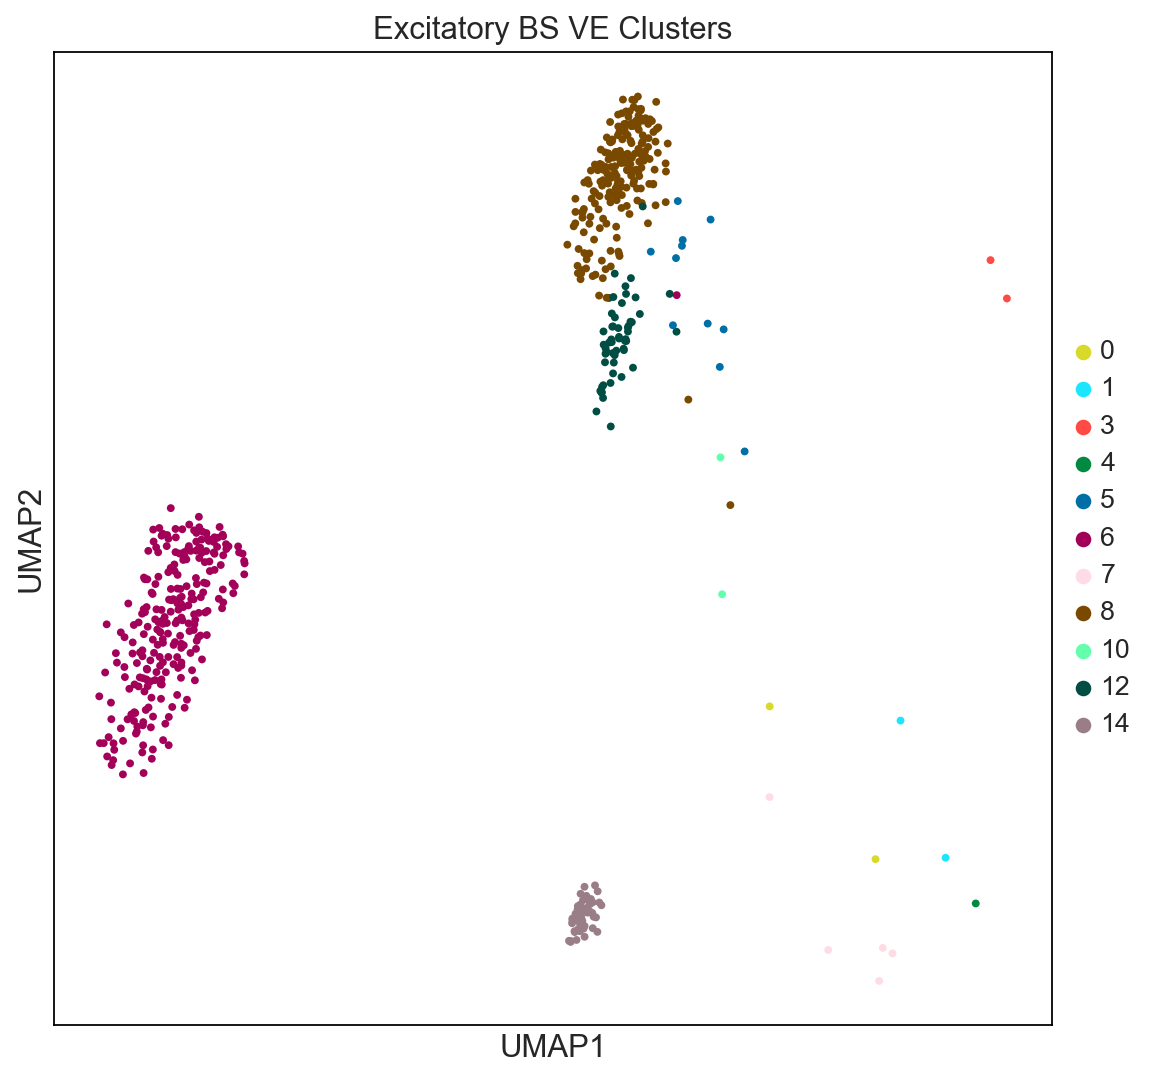

In [77]:
adata_exci_BS_VE = adata_exci_BS[adata_exci_BS.obs['Condition'].isin(['VE']),:].copy()

sc.set_figure_params(figsize=(8, 8))
sc.pl.umap(adata_exci_BS_VE, 
           color= ['PhenoGraph_clusters_exci'],
           ncols=2,
           edges = False,
           edges_width= 0.01,
           palette=["#d9d929", "#1CE6FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
    "#FFDBE5", "#7A4900", "#63FFAC", "#004D43", "#997D87"],
           size=50, 
           #legend_loc='on data', 
           legend_fontsize=12,
           legend_fontoutline=2,
           title=["Excitatory BS VE Clusters"])

In [66]:
cell_counts_per_cluster_BS_VE = adata_exci_BS_VE.obs.PhenoGraph_clusters_exci.value_counts()
cell_counts_per_cluster_BS_VE = cell_counts_per_cluster_BS_VE.to_frame()
cell_counts_per_cluster_BS_VE

PhenoGraph_clusters_exci
6                        252
8                        203
12                        54
14                        54
5                         11
7                          5
0                          2
1                          2
3                          2
10                         2
4                          1

### Heatmaps of gene expression

In [ ]:
marker_genes_dict = dict()

marker_genes_dict = {'Excitatory-BS':[
]}



In [ ]:
adata_exci_BS.layers['scaled'] = sc.pp.scale(adata_exci_BS, copy=True).X
sc.pl.matrixplot(adata_exci_BS, marker_genes_dict, groupby=['PhenoGraph_clusters_exci_str','Condition'], dendrogram=True,
                 colorbar_title='mean z-score', layer='scaled', vmin=-2, vmax=2, cmap='RdBu_r',swap_axes=True)

sc.pl.dotplot(adata_exci_BS, marker_genes_dict, groupby=['PhenoGraph_clusters_exci_str','Condition'], dendrogram=True,
             colorbar_title='mean z-score', layer='scaled', vmin=-1, vmax=1, cmap='RdBu_r',swap_axes=True)

sc.pl.dotplot(adata_exci_BS, marker_genes_dict, groupby=['PhenoGraph_clusters_exci_str','Condition'], dendrogram=False,
             colorbar_title='mean z-score', layer='scaled', vmin=-1, vmax=1, cmap='RdBu_r',swap_axes=True)

## Excitatory Cortex

In [52]:
adata_exci_cortex = adata_exci.copy()
adata_exci_cortex = adata_exci_cortex[adata_exci_cortex.obs['B_region'].isin(['Cortex']),:]
adata_exci_cortex.shape

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(6416, 17054)

In [53]:
adata_exci_cortex.obs.Condition.value_counts()

VE         3627
Control    2789
Name: Condition, dtype: int64

Trying to set attribute `.uns` of view, copying.


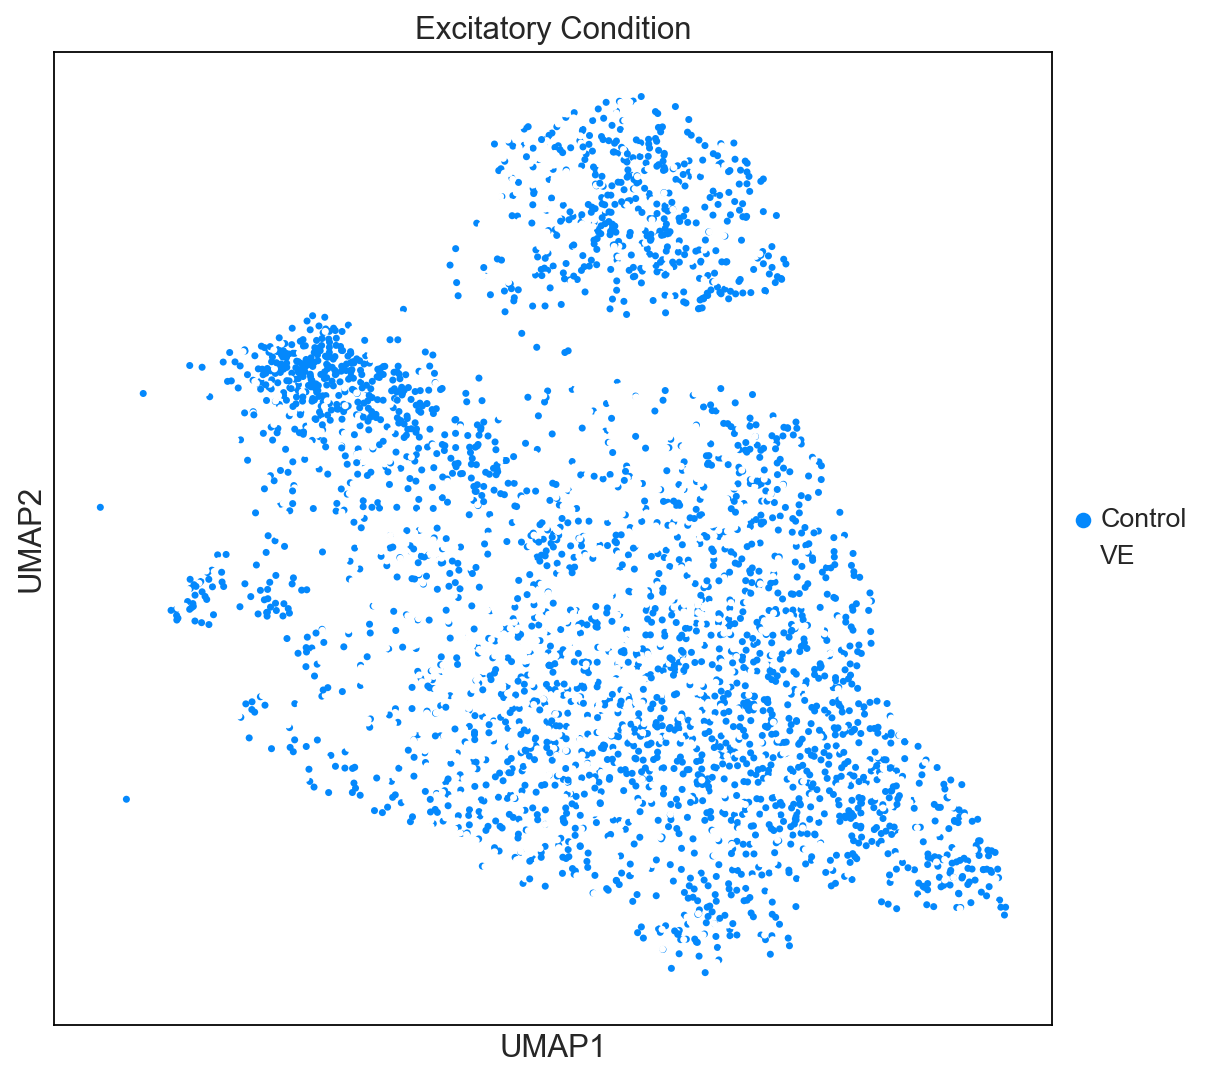

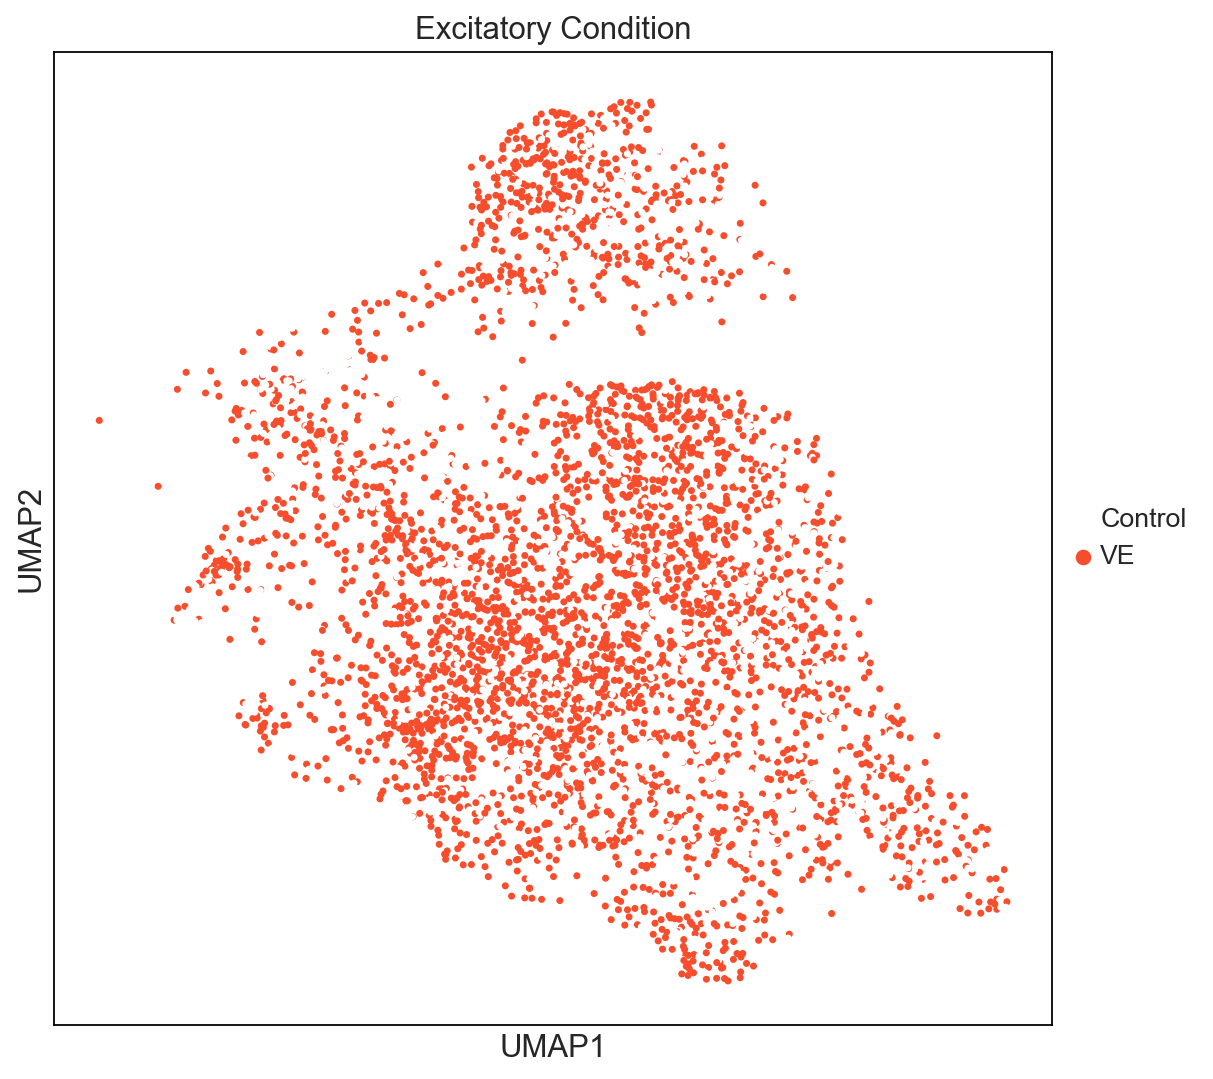

In [54]:
sc.set_figure_params(figsize=(8, 8))
sc.pl.umap(adata_exci_cortex, 
           color= ['Condition'],
           ncols=2,
           edges = False,
           edges_width= 0.01,
           palette=['#0488FC','#FFFFFFFF'],
           size=40, 
           #legend_loc='on data', 
           legend_fontsize=12,
           legend_fontoutline=2,
           title=["Excitatory Condition"])


sc.pl.umap(adata_exci_cortex, 
           color= ['Condition'],
           ncols=2,
           edges = False,
           edges_width= 0.01,
           palette=['#FFFFFFFF','#F64E2C'],
           size=40, 
           #legend_loc='on data', 
           legend_fontsize=12,
           legend_fontoutline=2,
           title=["Excitatory Condition"])

### Excitatory Cortex control 

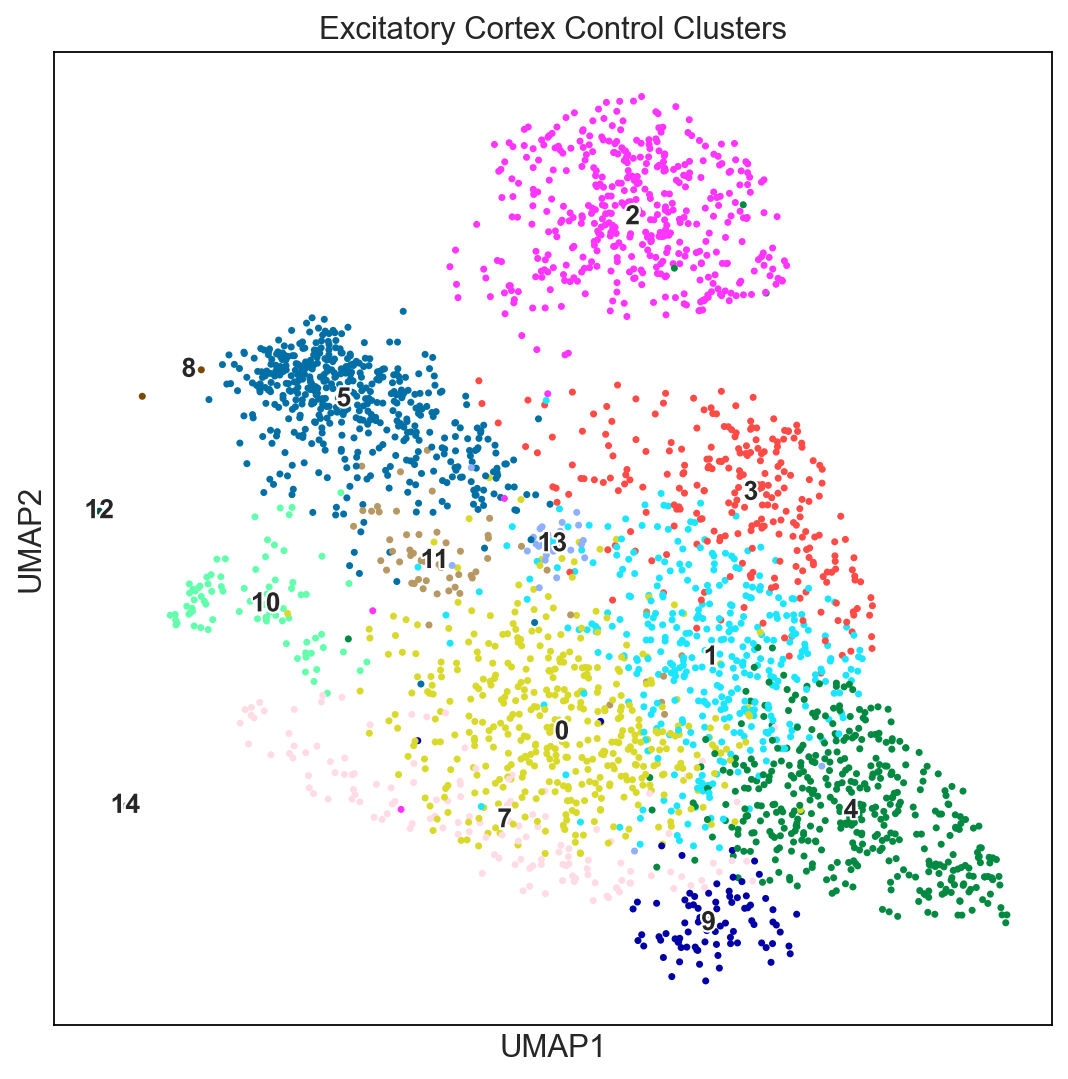

In [79]:
adata_exci_cortex_control = adata_exci_cortex[adata_exci_cortex.obs['Condition'].isin(['Control']),:].copy()

sc.set_figure_params(figsize=(8, 8))
sc.pl.umap(adata_exci_cortex_control, 
           color= ['PhenoGraph_clusters_exci'],
           ncols=2,
           edges = False,
           edges_width= 0.01,
           palette=["#d9d929", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6",
    "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87"],
           size=40, 
           legend_loc='on data', 
           legend_fontsize=12,
           legend_fontoutline=2,
           title=["Excitatory Cortex Control Clusters"])

In [63]:
cell_counts_per_cluster_cortex_control = adata_exci_cortex_control.obs.PhenoGraph_clusters_exci.value_counts()
cell_counts_per_cluster_cortex_control = cell_counts_per_cluster_cortex_control.to_frame()
cell_counts_per_cluster_cortex_control

PhenoGraph_clusters_exci
5                        485
0                        429
4                        425
2                        424
1                        377
3                        251
7                        136
9                         85
10                        84
11                        60
13                        28
8                          3
12                         1
14                         1

### Excitatory BS VE

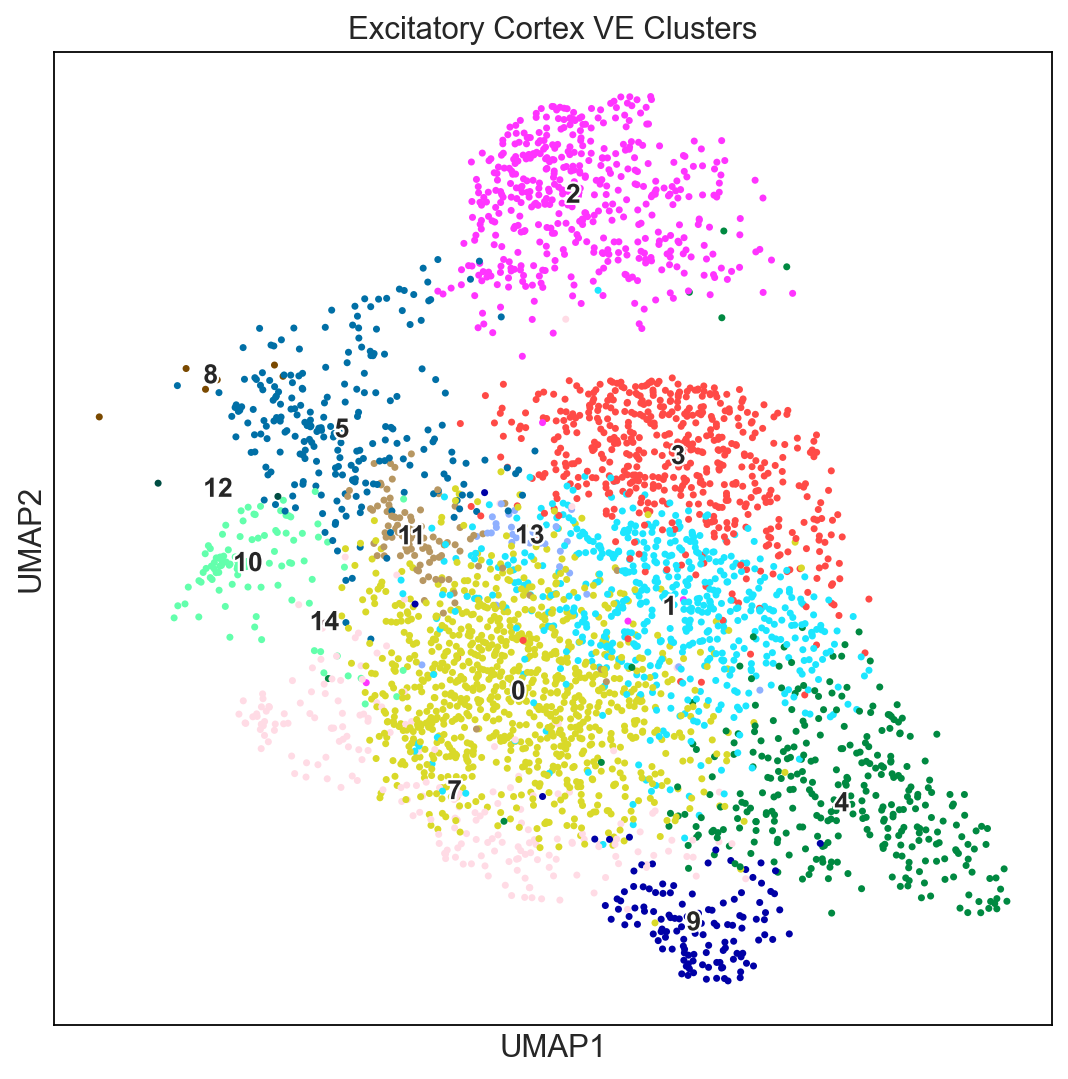

In [80]:
adata_exci_cortex_VE = adata_exci_cortex[adata_exci_cortex.obs['Condition'].isin(['VE']),:].copy()

sc.set_figure_params(figsize=(8, 8))
sc.pl.umap(adata_exci_cortex_VE, 
           color= ['PhenoGraph_clusters_exci'],
           ncols=2,
           edges = False,
           edges_width= 0.01,
           palette=["#d9d929", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6",
    "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87"],
           size=40, 
           legend_loc='on data', 
           legend_fontsize=12,
           legend_fontoutline=2,
           title=["Excitatory Cortex VE Clusters"])

In [64]:
cell_counts_per_cluster_cortex_VE = adata_exci_cortex_VE.obs.PhenoGraph_clusters_exci.value_counts()
cell_counts_per_cluster_cortex_VE = cell_counts_per_cluster_cortex_VE.to_frame()
cell_counts_per_cluster_cortex_VE

PhenoGraph_clusters_exci
0                        947
1                        572
3                        533
2                        462
4                        321
5                        231
7                        205
9                        126
11                        96
10                        93
13                        31
8                          7
12                         2
14                         1

### Heatmaps of gene expression

In [ ]:
marker_genes_dict = dict()

marker_genes_dict = {'Excitatory-BS':[
]}



In [ ]:
adata_exci_cortex.layers['scaled'] = sc.pp.scale(adata_exci_cortex, copy=True).X
sc.pl.matrixplot(adata_exci_cortex, marker_genes_dict, groupby=['PhenoGraph_clusters_exci_str','Condition'], dendrogram=True,
                 colorbar_title='mean z-score', layer='scaled', vmin=-2, vmax=2, cmap='RdBu_r',swap_axes=True)

sc.pl.dotplot(adata_exci_cortex, marker_genes_dict, groupby=['PhenoGraph_clusters_exci_str','Condition'], dendrogram=True,
             colorbar_title='mean z-score', layer='scaled', vmin=-1, vmax=1, cmap='RdBu_r',swap_axes=True)

sc.pl.dotplot(adata_exci_cortex, marker_genes_dict, groupby=['PhenoGraph_clusters_exci_str','Condition'], dendrogram=False,
             colorbar_title='mean z-score', layer='scaled', vmin=-1, vmax=1, cmap='RdBu_r',swap_axes=True)

In [ ]:
adata_exci_cortex.obs.PhenoGraph_clusters_exci.value_counts()

### Make a grouped bar plot of the number of cells per cluster per condition

**Brainstem**

In [67]:
# First merge the 2 data frames by indeces
mergedDF= cell_counts_per_cluster_BS_ctrl.merge(cell_counts_per_cluster_BS_VE, left_index=True, right_index=True, suffixes=('_Control', '_VE'),how = 'outer')
mergedDF.rename(columns = {'PhenoGraph_clusters_exci_Control' : 'Control', 'PhenoGraph_clusters_exci_VE' : 'VE'}, inplace = True)
mergedDF

Control     VE
0       NaN    2.0
1       NaN    2.0
2       1.0    NaN
3       NaN    2.0
4       NaN    1.0
5       2.0   11.0
6     180.0  252.0
7       NaN    5.0
8      33.0  203.0
10      2.0    2.0
12     10.0   54.0
14      NaN   54.0

In [68]:
mergedDF = mergedDF.reset_index()
mergedDF = mergedDF.melt(id_vars=["index"])
mergedDF.rename(columns = {'index' : 'ClusterID', 'variable' : 'Condition', 'value' : 'N_cells'}, inplace = True)
mergedDF

ClusterID Condition  N_cells
0           0   Control      NaN
1           1   Control      NaN
2           2   Control      1.0
3           3   Control      NaN
4           4   Control      NaN
5           5   Control      2.0
6           6   Control    180.0
7           7   Control      NaN
8           8   Control     33.0
9          10   Control      2.0
10         12   Control     10.0
11         14   Control      NaN
12          0        VE      2.0
13          1        VE      2.0
14          2        VE      NaN
15          3        VE      2.0
16          4        VE      1.0
17          5        VE     11.0
18          6        VE    252.0
19          7        VE      5.0
20          8        VE    203.0
21         10        VE      2.0
22         12        VE     54.0
23         14        VE     54.0

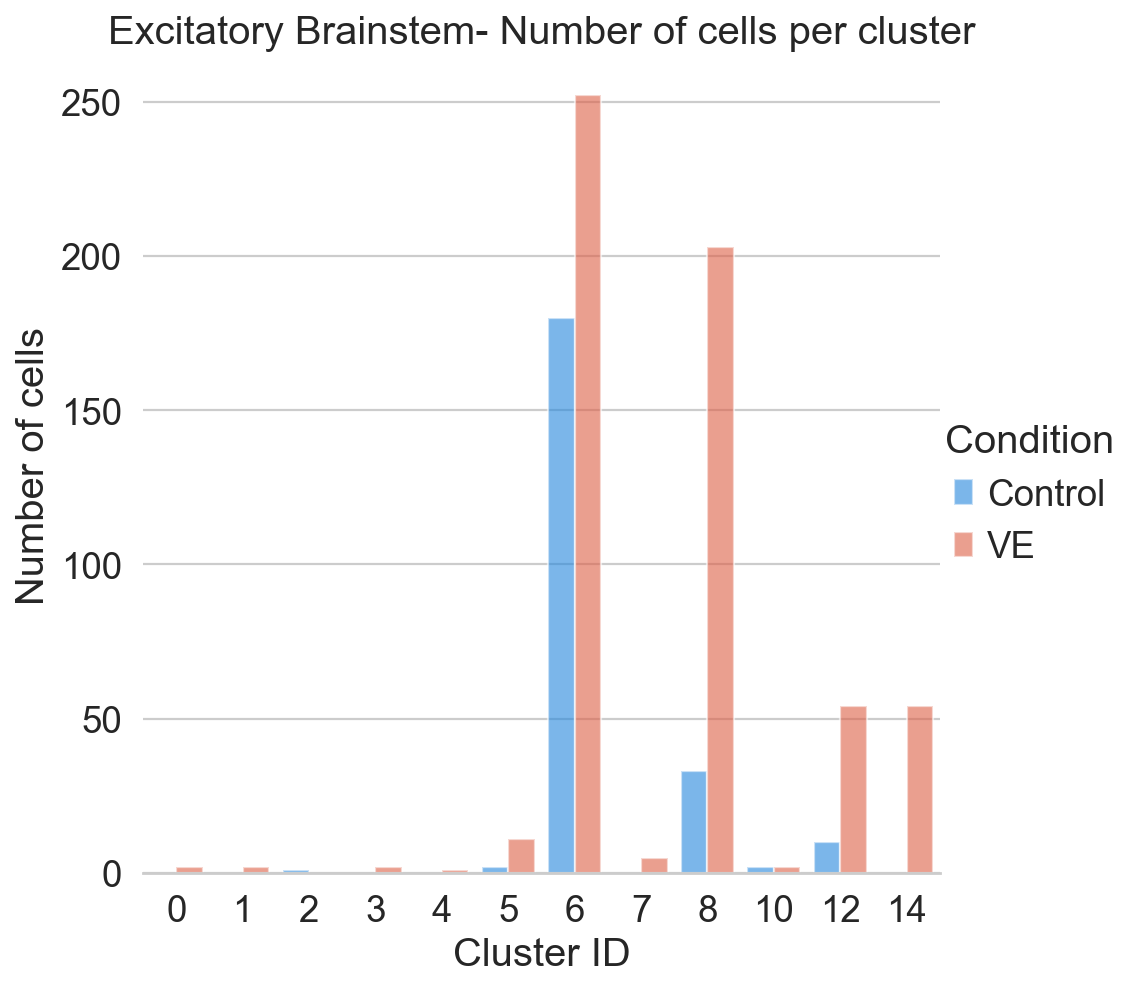

In [69]:
sns.set(font_scale=1.5, style = 'whitegrid') 
# Draw a nested barplot by species and sex
g = sns.catplot(
    data=mergedDF, kind="bar",
    x="ClusterID", y="N_cells", hue="Condition",
    ci="sd", palette=['#0488FC','#F64E2C'], alpha=.6, height=6
)
g.despine(left=True)
g.set(title='Excitatory Brainstem- Number of cells per cluster')
g.set_axis_labels("Cluster ID", "Number of cells")

**Cortex**

In [73]:
# First merge the 2 data frames by indeces
mergedDF_2= cell_counts_per_cluster_cortex_control.merge(cell_counts_per_cluster_cortex_VE, left_index=True, right_index=True, suffixes=('_Control', '_VE'), how = 'outer')
mergedDF_2.rename(columns = {'PhenoGraph_clusters_exci_Control' : 'Control', 'PhenoGraph_clusters_exci_VE' : 'VE'}, inplace = True)
mergedDF_2

Control   VE
0       429  947
1       377  572
2       424  462
3       251  533
4       425  321
5       485  231
7       136  205
8         3    7
9        85  126
10       84   93
11       60   96
12        1    2
13       28   31
14        1    1

In [74]:
mergedDF_2 = mergedDF_2.reset_index()
mergedDF_2 = mergedDF_2.melt(id_vars=["index"])
mergedDF_2.rename(columns = {'index' : 'ClusterID', 'variable' : 'Condition', 'value' : 'N_cells'}, inplace = True)
mergedDF_2

ClusterID Condition  N_cells
0          0   Control      429
1          1   Control      377
2          2   Control      424
3          3   Control      251
4          4   Control      425
5          5   Control      485
6          7   Control      136
7          8   Control        3
8          9   Control       85
9         10   Control       84
10        11   Control       60
11        12   Control        1
12        13   Control       28
13        14   Control        1
14         0        VE      947
15         1        VE      572
16         2        VE      462
17         3        VE      533
18         4        VE      321
19         5        VE      231
20         7        VE      205
21         8        VE        7
22         9        VE      126
23        10        VE       93
24        11        VE       96
25        12        VE        2
26        13        VE       31
27        14        VE        1

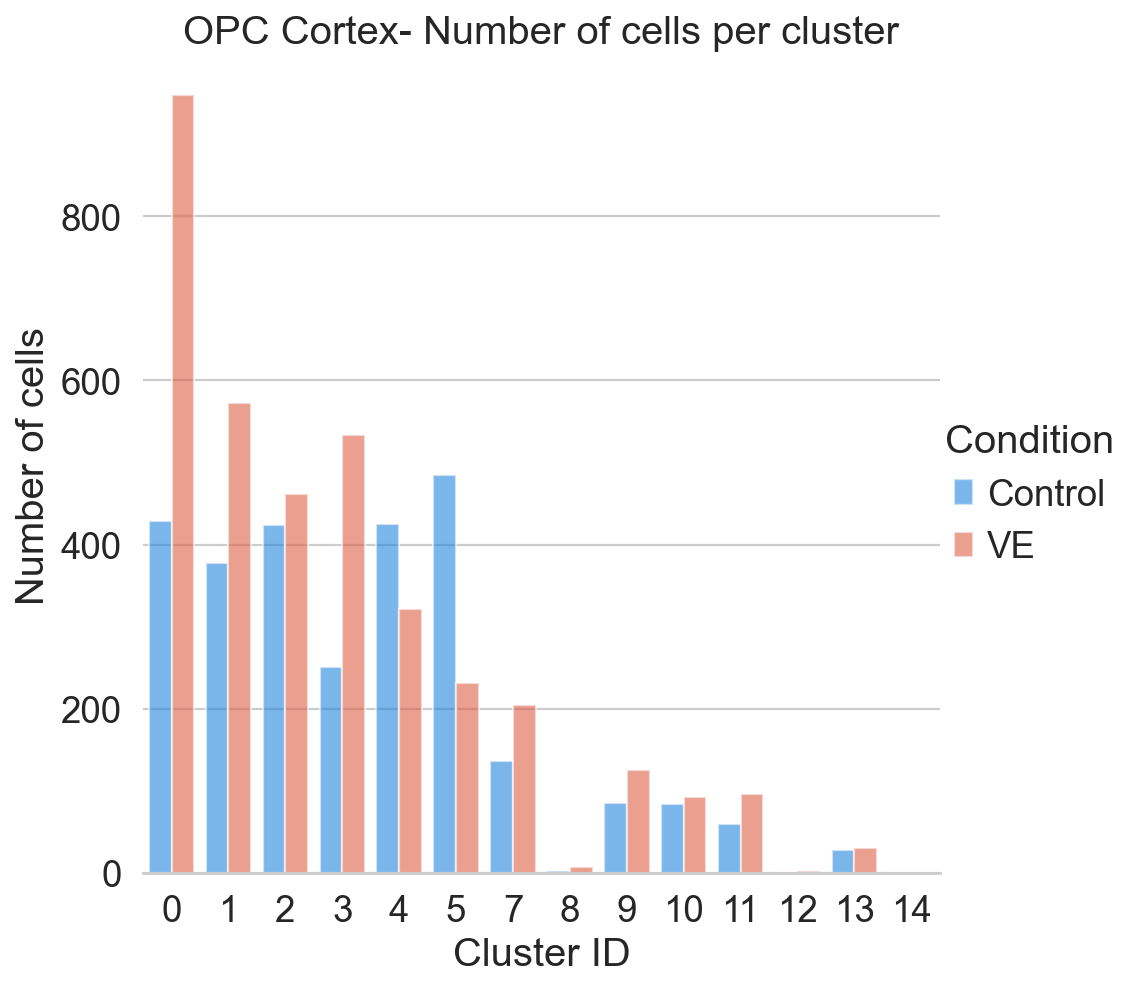

In [75]:
sns.set(font_scale=1.5, style = 'whitegrid') 
# Draw a nested barplot by species and sex
g = sns.catplot(
    data=mergedDF_2, kind="bar",
    x="ClusterID", y="N_cells", hue="Condition",
    ci="sd", palette=['#0488FC','#F64E2C'], alpha=.6, height=6
)
g.despine(left=True)
g.set(title='OPC Cortex- Number of cells per cluster')
g.set_axis_labels("Cluster ID", "Number of cells")